# Import necessary libraries and upload dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier 
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import random
from scipy.stats import loguniform
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

If using Google colab instead of Jupyter Notebooks uncomment the following cell

In [ ]:
#from google.colab import files
#uploaded = files.upload()

And again if using Google Collab comment the first pd.read_csv statement and uncomment the second

In [ ]:
# import raw data as df

df = pd.read_csv('/Users/oriold/Desktop/CreditCardDataFinal.csv')

#df = pd.read_csv('/content/CreditCardDataFinal.csv')

df.head(2)

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
0,#3577 209,14-Oct-20,Wednesday,19,Visa,Tap,£5,POS,Entertainment,United Kingdom,United Kingdom,United Kingdom,M,25.2,RBS,0
1,#3039 221,14-Oct-20,Wednesday,17,MasterCard,PIN,£288,POS,Services,USA,USA,USA,F,49.6,Lloyds,0


# Data Cleaning

Let's start to familiarise ourselves with the dataset by looking at the shape of it and understanding the data it contains

In [ ]:
# check the shape of the dataset 
df.shape

(100000, 16)

In [ ]:
# check data in dataframe

df.describe(include="all")

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
count,100000,100000,100000,100000.000000,100000,100000,99994,100000,99990,100000,99995,100000,99996,100000.000000,100000,100000.000000
unique,95680,4,4,NaN,2,3,396,3,10,5,5,5,2,NaN,8,NaN
top,#2547 017,14-Oct-20,Wednesday,NaN,Visa,PIN,£17,Online,Children,United Kingdom,United Kingdom,United Kingdom,M,NaN,Barclays,NaN
freq,5,50184,50177,NaN,53812,49976,2153,33481,10679,71199,60905,81859,50875,NaN,29936,NaN
mean,NaN,NaN,NaN,14.562870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.993770,NaN,0.071950
std,NaN,NaN,NaN,5.308195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.948494,NaN,0.258406
min,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.000000,NaN,0.000000
25%,NaN,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.200000,NaN,0.000000
50%,NaN,NaN,NaN,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.900000,NaN,0.000000
75%,NaN,NaN,NaN,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.700000,NaN,0.000000


We can see that certain columns such as "Amount", "Merchant Group", "Shipping Address" or "Gender" have some missing values. There's also a majority of columns with categorical data which will need to be encoded before we can feed the data to a machine learning algorithm.

In [ ]:
# create separate df for categorical values and understand the distribution of each category

df_cat = df[['Date', 'Day of Week', 'Type of Card', 'Entry Mode', 'Type of Transaction', 'Merchant Group', 'Country of Transaction', 
             'Shipping Address', 'Country of Residence','Gender','Bank']]

for i in df_cat.columns:
  print(df[i].value_counts())

14-Oct-20    50184
13-Oct-20    49814
16-Oct-20        1
15-Oct-20        1
Name: Date, dtype: int64
Wednesday    50177
Tuesday      49797
Friday          14
Thursday        12
Name: Day of Week, dtype: int64
Visa          53812
MasterCard    46188
Name: Type of Card, dtype: int64
PIN    49976
CVC    33481
Tap    16543
Name: Entry Mode, dtype: int64
Online    33481
ATM       33274
POS       33245
Name: Type of Transaction, dtype: int64
Children         10679
Restaurant       10078
Services         10017
Gaming           10011
Fashion           9987
Subscription      9977
Food              9847
Entertainment     9839
Products          9839
Electronics       9716
Name: Merchant Group, dtype: int64
United Kingdom    71199
USA                7298
Russia             7257
China              7152
India              7094
Name: Country of Transaction, dtype: int64
United Kingdom    60905
USA               10042
Russia             9799
China              9698
India              9551
Name: Shippi

Some of the categories are very unbalanced, for example date or day of the week. Also there's only 1 observation for each 15/10 and 16/10 but there's multiple observations for day of the week Thursday and Friday. It could be that some day of the week are misscategorised.

In [ ]:
# check the dates the are classified as "Thursday" and "Friday"

days = ['Thursday', 'Friday']

df.loc[df['Day of Week'].isin(days)]

,Transaction ID,Date,Day of Week,Time,Type of Card,Entry Mode,Amount,Type of Transaction,Merchant Group,Country of Transaction,Shipping Address,Country of Residence,Gender,Age,Bank,Fraud
904,#3314 299,14-Oct-20,Thursday,7,MasterCard,Tap,£25,POS,Gaming,United Kingdom,United Kingdom,United Kingdom,M,31.2,Halifax,0
1731,#3522 079,13-Oct-20,Thursday,12,MasterCard,PIN,£166,ATM,Gaming,United Kingdom,United Kingdom,United Kingdom,M,55.3,HSBC,0
2237,#2562 403,13-Oct-20,Thursday,19,Visa,PIN,£24,ATM,Fashion,United Kingdom,United Kingdom,United Kingdom,F,39.6,Lloyds,0
8421,#2997 386,13-Oct-20,Friday,12,MasterCard,PIN,£198,POS,Gaming,United Kingdom,United Kingdom,United Kingdom,F,53.0,Barlcays,0
9722,#3084 661,13-Oct-20,Friday,11,MasterCard,PIN,£13,ATM,Services,United Kingdom,United Kingdom,United Kingdom,M,42.2,Metro,0
10483,#2982 416,13-Oct-20,Thursday,7,Visa,PIN,£294,ATM,Gaming,United Kingdom,United Kingdom,United Kingdom,M,38.6,Barlcays,0
20296,#3066 613,13-Oct-20,Thursday,10,Visa,PIN,£169,POS,Fashion,United Kingdom,United Kingdom,United Kingdom,M,48.6,Barclays,0
21285,#2768 579,13-Oct-20,Friday,10,Visa,PIN,£171,ATM,Children,United Kingdom,United Kingdom,United Kingdom,M,52.8,Lloyds,0
27809,#3634 270,14-Oct-20,Friday,19,Visa,PIN,£285,ATM,Services,United Kingdom,United Kingdom,United Kingdom,F,29.1,Barclays,0
30844,#2895 855,13-Oct-20,Friday,7,Visa,CVC,£25,Online,Fashion,United Kingdom,United Kingdom,United Kingdom,M,33.4,Monzo,0


As suspected some days of the week are misscategorised, so we'll recategorise them correctly.

In [ ]:
# create new 'Day of the Week' column with the values correctly categorised 

df['Day of the Week Reworked'] = np.where(df['Date']=='13-Oct-20',"Tuesday",
                        np.where(df['Date']=='14-Oct-20',"Wednesday",
                        np.where(df['Date']=='15-Oct-20',"Thursday",
                        np.where(df['Date']=='16-Oct-20',"Friday","unknown"))))

Now let's check if the newly created column for day of the week makes more sense based on the dates

In [ ]:
# create separate df for categorical values

df_days = df[['Date', 'Day of Week', 'Day of the Week Reworked']]

for i in df_days.columns:
  print(df[i].value_counts())

14-Oct-20    50184
13-Oct-20    49814
16-Oct-20        1
15-Oct-20        1
Name: Date, dtype: int64
Wednesday    50177
Tuesday      49797
Friday          14
Thursday        12
Name: Day of Week, dtype: int64
Wednesday    50184
Tuesday      49814
Friday           1
Thursday         1
Name: Day of the Week Reworked, dtype: int64


Moving forward we'll use "Day of the Week Reworked". Now let's look at numerical variables

In [ ]:
# create df for numerical variables 

df_num = df[['Time', 'Amount', 'Age','Fraud']]

df_num.describe()

,Time,Age,Fraud
count,100000.000000,100000.000000,100000.000000
mean,14.562870,44.993770,0.071950
std,5.308195,9.948494,0.258406
min,0.000000,15.000000,0.000000
25%,10.000000,38.200000,0.000000
50%,15.000000,44.900000,0.000000
75%,19.000000,51.700000,0.000000
max,24.000000,86.100000,1.000000


"Amount" didn't come up as a numerical category, let's try to find why

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Transaction ID            100000 non-null  object 
 1   Date                      100000 non-null  object 
 2   Day of Week               100000 non-null  object 
 3   Time                      100000 non-null  int64  
 4   Type of Card              100000 non-null  object 
 5   Entry Mode                100000 non-null  object 
 6   Amount                    99994 non-null   object 
 7   Type of Transaction       100000 non-null  object 
 8   Merchant Group            99990 non-null   object 
 9   Country of Transaction    100000 non-null  object 
 10  Shipping Address          99995 non-null   object 
 11  Country of Residence      100000 non-null  object 
 12  Gender                    99996 non-null   object 
 13  Age                       100000 non-null  fl

I noticed that 'Amount' is not a float which it should be, probably due to the pound £ sign, let's remove that

In [ ]:
# remove pound £ sign

df['Amount'] = df['Amount'].astype(str).str.replace('\D+', '')

# convert amount series to numeric

df['Amount'] = pd.to_numeric(df['Amount'],errors='coerce')

In [ ]:
# now let's describe the numerical variables again

df_num = df[['Time', 'Amount', 'Age', 'Fraud']]

df_num.describe()

,Time,Amount,Age,Fraud
count,100000.000000,99994.000000,100000.000000,100000.000000
mean,14.562870,112.578515,44.993770,0.071950
std,5.308195,123.433893,9.948494,0.258406
min,0.000000,5.000000,15.000000,0.000000
25%,10.000000,17.000000,38.200000,0.000000
50%,15.000000,30.000000,44.900000,0.000000
75%,19.000000,208.000000,51.700000,0.000000
max,24.000000,400.000000,86.100000,1.000000


The mean for time, amount and age is not zero-centered and some machine learning algorithms work better and faster with zero-centered features. Amount is also missing in 6 transactions, it would probably be a good idea to create a new category to see if there's correlation between amount missing and fraudulent transactions.

Let's look at the days of the week again

In [ ]:
df['Day of the Week Reworked'].value_counts()

Wednesday    50184
Tuesday      49814
Friday           1
Thursday         1
Name: Day of the Week Reworked, dtype: int64

There's still 2 entries which are genuinely Thursday and Friday but the data is meant to be only from 2 days (13th and 14th). Therefore we will eliminate this entries as there wouldn't be enough data on these 2 days to be able to predict any outcomes.

In [ ]:
# drop rows for "Thursday" and "Friday" 15th and 16th

values = ['Thursday', 'Friday']

#drop rows that contain any value in the list
df = df[df['Day of the Week Reworked'].isin(values) == False]

In [ ]:
df['Day of the Week Reworked'].value_counts()

Wednesday    50184
Tuesday      49814
Name: Day of the Week Reworked, dtype: int64

Now let's create different features to help us with the visualisation of this data set.

In [ ]:
#create bins by amount groups including null

bins = [0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400]
names = ['0-25','25-50','50-75','75-100','100-125','125-150','150-175','175-200','200-225','225-250',
         '250-275','275-300','300-325','325-350','350-375','375-400']

df['amount_range'] = pd.cut(df['Amount'], bins, labels=names)

In [ ]:
#create dimension for amount null

df['amount_range'] = df['amount_range'].cat.add_categories("undefined_amount").fillna("undefined_amount")

#add 0 amount when amount is null

df['Amount'] = df['Amount'].fillna(0)

In [ ]:
#create dimension for merchant group null

df['Merchant Group'] = df['Merchant Group'].fillna("undefined_merchant")

#create dimension for shipping address missing

df['Shipping Address'] = df['Shipping Address'].fillna("undefined_shipping")

#create dimension for gender missing

df['Gender'] = df['Gender'].fillna("undefined_gender")

In [ ]:
#create dimension for country of transactions different from country of residence

transaction_residence_relationship = []

for i, j in zip(df['Country of Transaction'], df['Country of Residence']):
  if i == j:
    transaction_residence_relationship.append(1)
  elif i!= j:
    transaction_residence_relationship.append(0)

df['transaction_residence_relationship'] = transaction_residence_relationship

#create dimension for country of residence different than shipping address

residence_shipping_relationship = []

for i, j in zip(df['Country of Residence'], df['Shipping Address']):
  if i == j:
    residence_shipping_relationship.append(1)
  elif i!= j:
    residence_shipping_relationship.append(0)

df['residence_shipping_relationship'] = residence_shipping_relationship

#create dimension for country of transaction different than shipping address

transaction_shipping_relationship = []

for i, j in zip(df['Country of Transaction'], df['Shipping Address']):
  if i == j:
    transaction_shipping_relationship.append(1)
  elif i!= j:
    transaction_shipping_relationship.append(0)

df['transaction_shipping_relationship'] = transaction_shipping_relationship

# EDA

To help visualise the distribution of "fraudulent" and "legitimate" transactions, I'll create two new series in the data set that will count "fraudulent" and "legitimate" transactions separately.

In [ ]:
# create 2 new columns with count of fraud and count of legit for visualization purposes

fraudulent = []

for i in df['Fraud']:
  if i == 1:
    fraudulent.append(1)
  else:
    fraudulent.append(np.nan)

df['fraudulent'] = fraudulent

legit = []

for i in df['Fraud']:
  if i == 0:
    legit.append(1)
  else:
    legit.append(np.nan)

df['legit'] = legit

Now let's start by visualising all categorical variables.

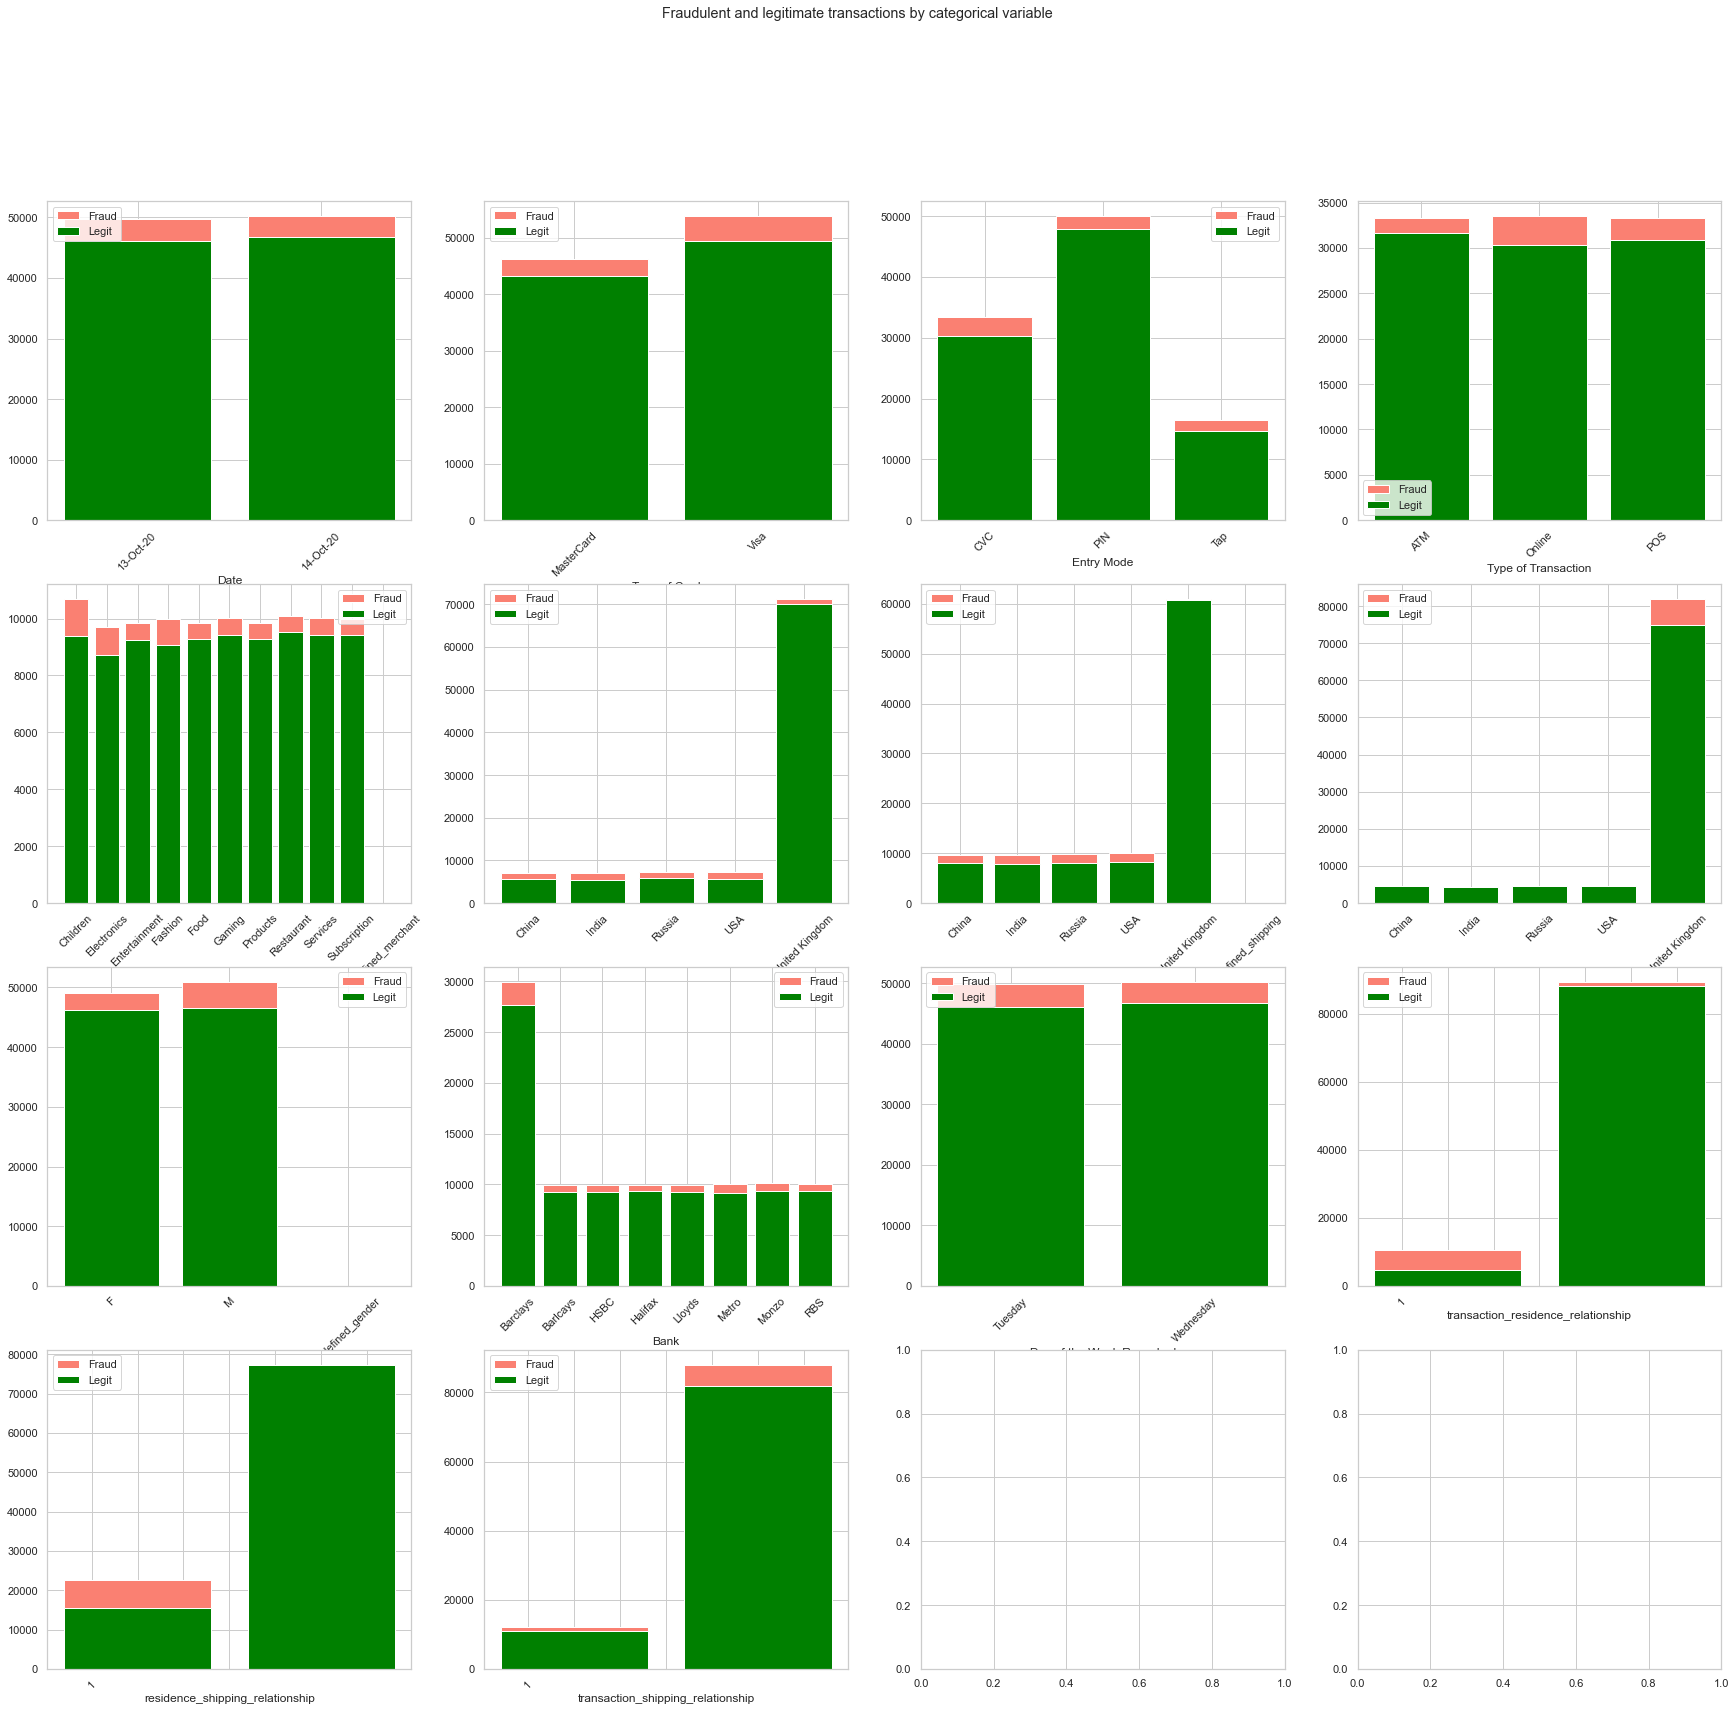

In [ ]:
# create multiple charts for categorical variables using df_cat

df_cat = df[['Date', 'Type of Card', 'Entry Mode', 'Type of Transaction', 'Merchant Group', 'Country of Transaction', 
             'Shipping Address', 'Country of Residence','Gender','Bank','Day of the Week Reworked','transaction_residence_relationship',
             'residence_shipping_relationship', 'transaction_shipping_relationship']]

# create bar chart for each categorical variable

i,j=0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(df_cat.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(30, 27))
for col in df_cat:

    group = df[[col, 'fraudulent', 'legit']]
    groupd = group.groupby(col).sum()
    x = groupd.index.values
    y_fraud = groupd.fraudulent
    y_legit = groupd.legit    
    labels = groupd.index.values
    legend = ['Fraud', 'Legit']

    #create chart 

    axs[i][j].bar(x, y_fraud, color='salmon', bottom=y_legit)
    axs[i][j].bar(x, y_legit, color='green')
    #axs[i][j].set_ylabel('Count of\nTransactions')
    axs[i][j].grid(True)
    axs[i][j].set_xlabel(col)
    axs[i][j].set_xticklabels(labels=labels, rotation=45)
    axs[i][j].tick_params(axis='both', which='minor', labelsize=3)
    axs[i][j].legend(legend)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.suptitle("Fraudulent and legitimate transactions by categorical variable", size='large')
plt.show()


It feels that some categorical varibles have a much larger percentage of fraudulent transactions. However due to the imbalanced distribution of fraudulent and legitimate transactions it's not so easy to spot that in the previous visualisation. Let's try to fix that by looking at the same data but using a 100% stacked view.

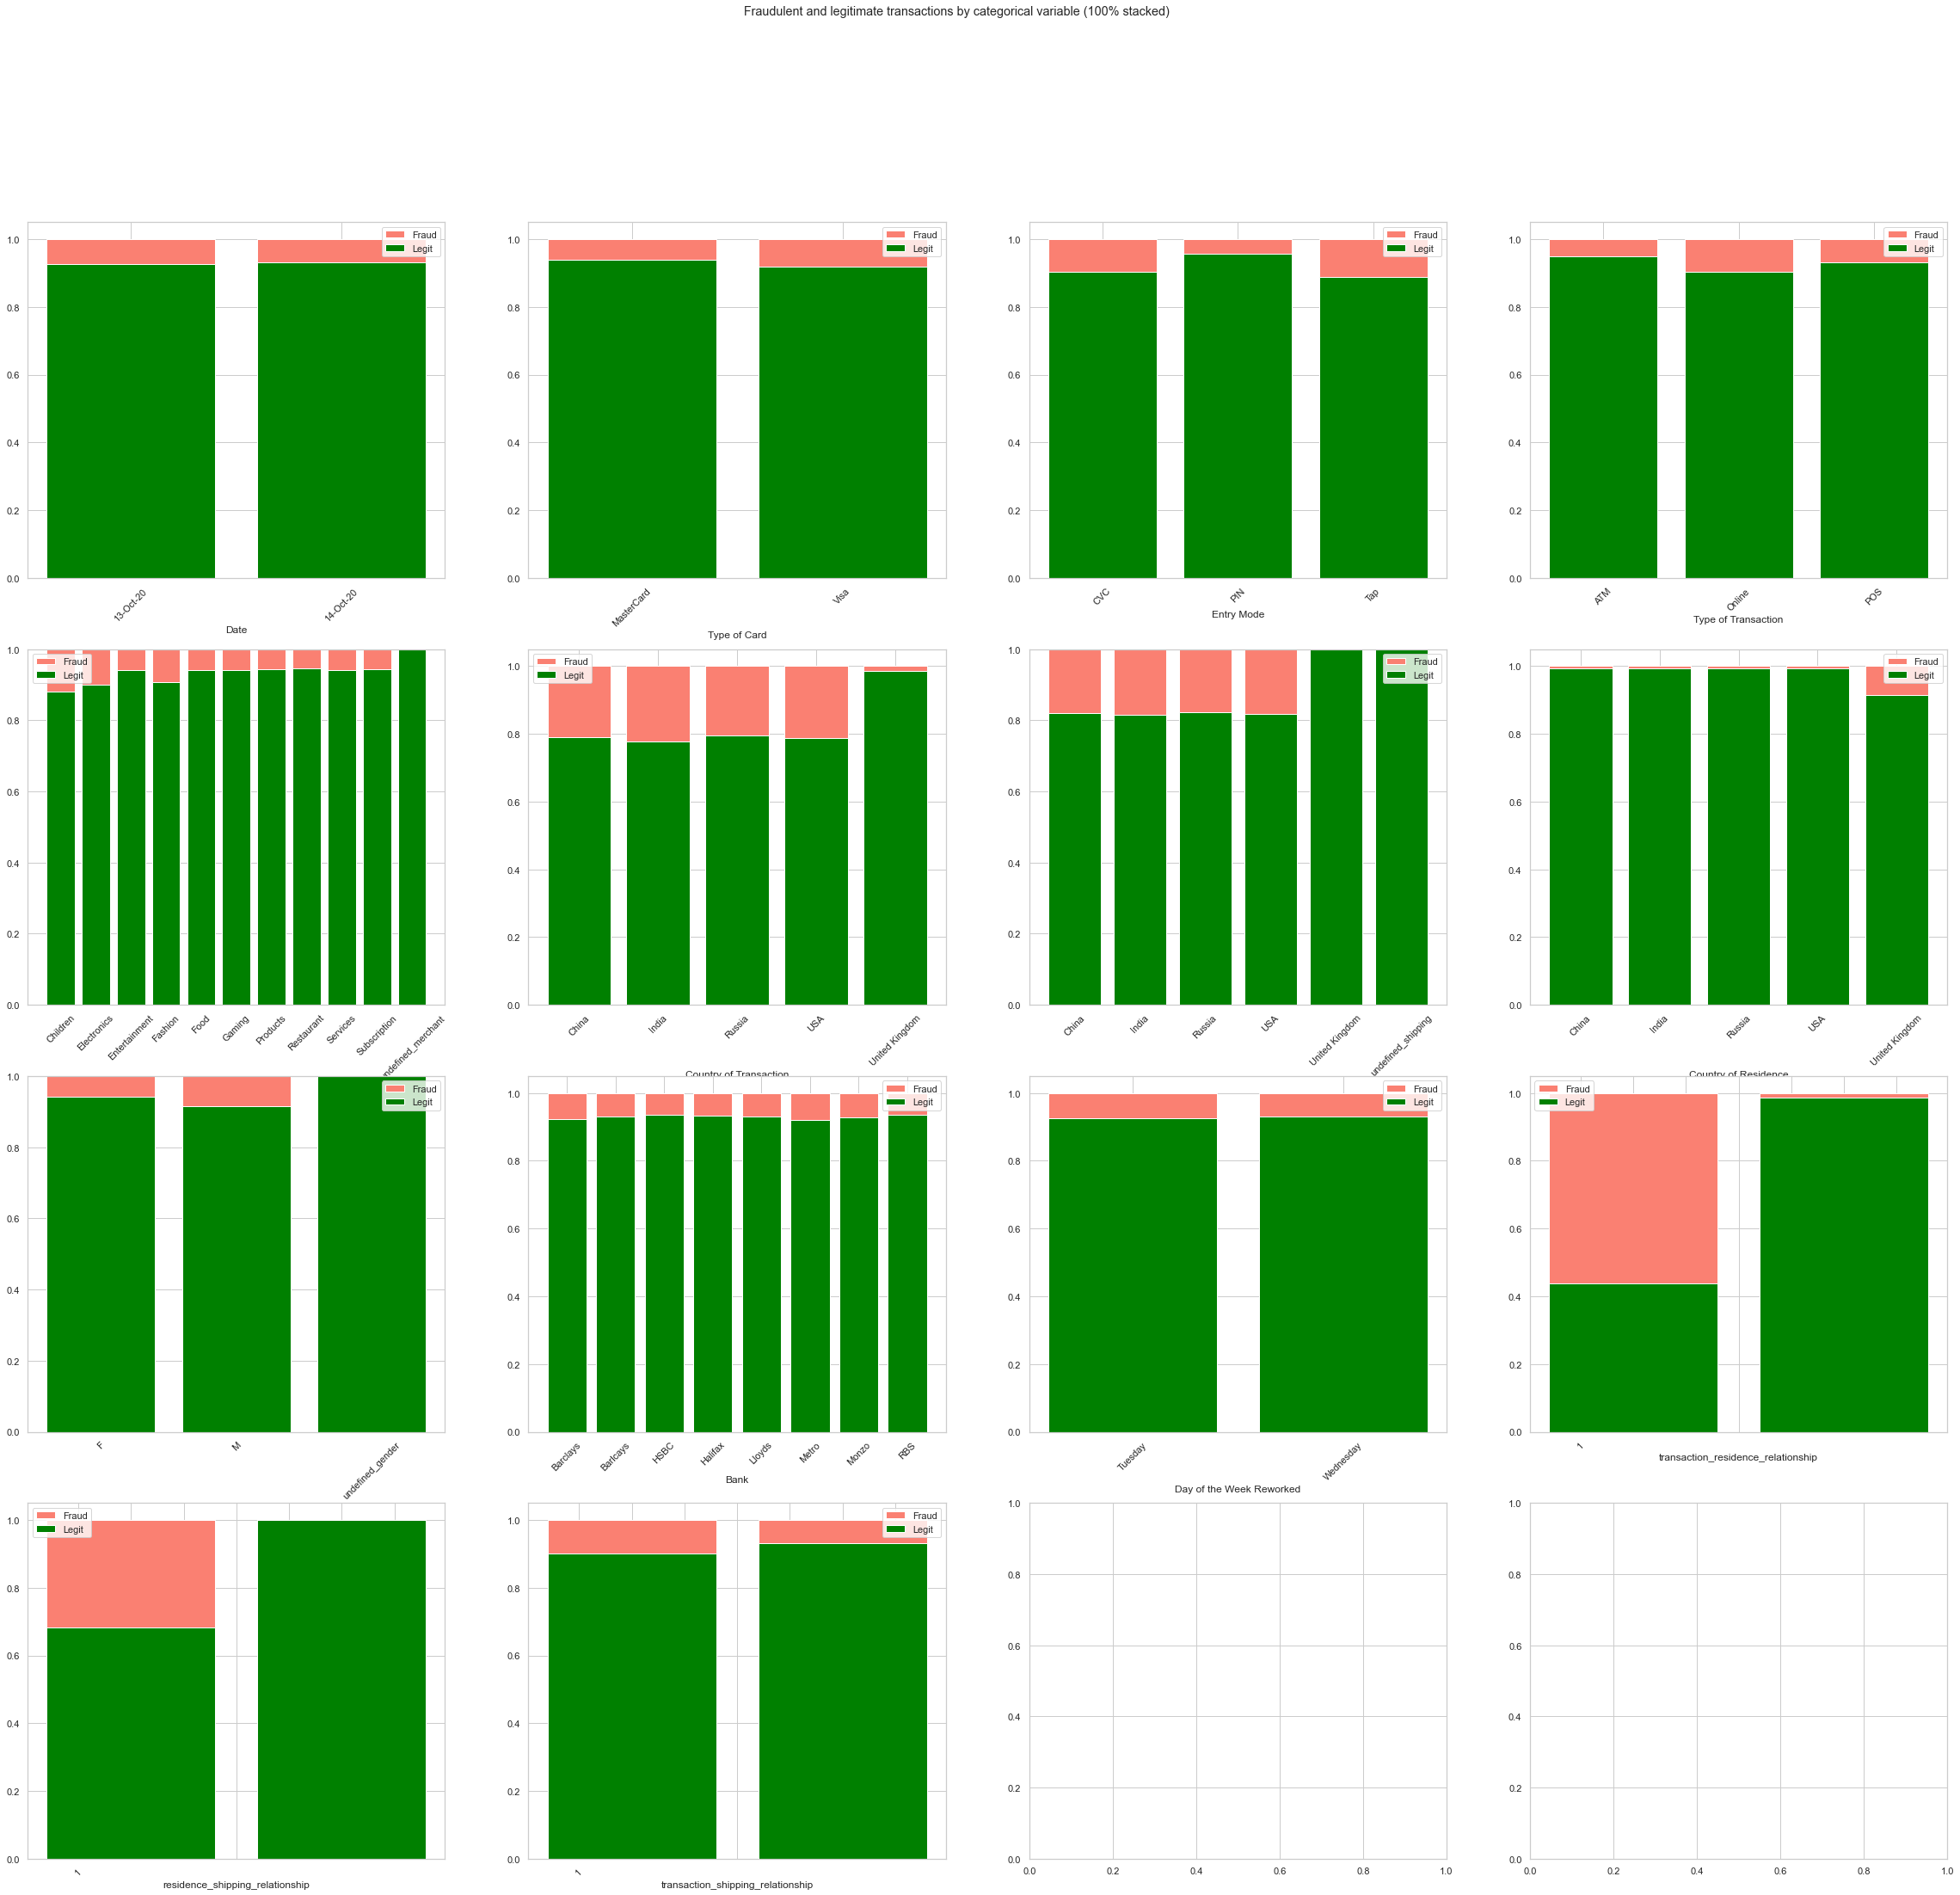

In [ ]:
# create multiple charts for categorical variables using df_cat

df_cat = df[['Date', 'Type of Card', 'Entry Mode', 'Type of Transaction', 'Merchant Group', 'Country of Transaction', 
             'Shipping Address', 'Country of Residence','Gender','Bank','Day of the Week Reworked','transaction_residence_relationship',
             'residence_shipping_relationship', 'transaction_shipping_relationship']]

# create bar chart for each categorical variable

i,j=0,0
PLOTS_PER_ROW = 4
fig, axs = plt.subplots(math.ceil(len(df_cat.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(40, 35))
for col in df_cat:

    group = df[[col, 'fraudulent', 'legit']]
    groupd = group.groupby(col).sum()
    x = groupd.index.values
    y_fraud = groupd.fraudulent/(groupd.fraudulent+groupd.legit)
    y_legit = groupd.legit/(groupd.fraudulent+groupd.legit) 
    labels = groupd.index.values
    legend = ['Fraud', 'Legit']

    #create chart 

    axs[i][j].bar(x, y_fraud, color='salmon', bottom=y_legit)
    axs[i][j].bar(x, y_legit, color='green')
    #axs[i][j].set_ylabel('Count of\nTransactions')
    axs[i][j].grid(True)
    axs[i][j].set_xlabel(col)
    axs[i][j].set_xticklabels(labels=labels, rotation=45)
    axs[i][j].tick_params(axis='both', which='minor', labelsize=3)
    axs[i][j].legend(legend)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.suptitle("Fraudulent and legitimate transactions by categorical variable (100% stacked)", size='large')
plt.show()


Now we can clearly see that certain Country of Transaction or Country of Shipping have significantly higher fraud rates. Additionally, the features we created have revealed some important characteristics of the data set. For example we can see that approximately 60% of transactions where the Country of Transactions is different than the country of residence are actually fraudulent.

Let's create similar visualisations for numerical variables

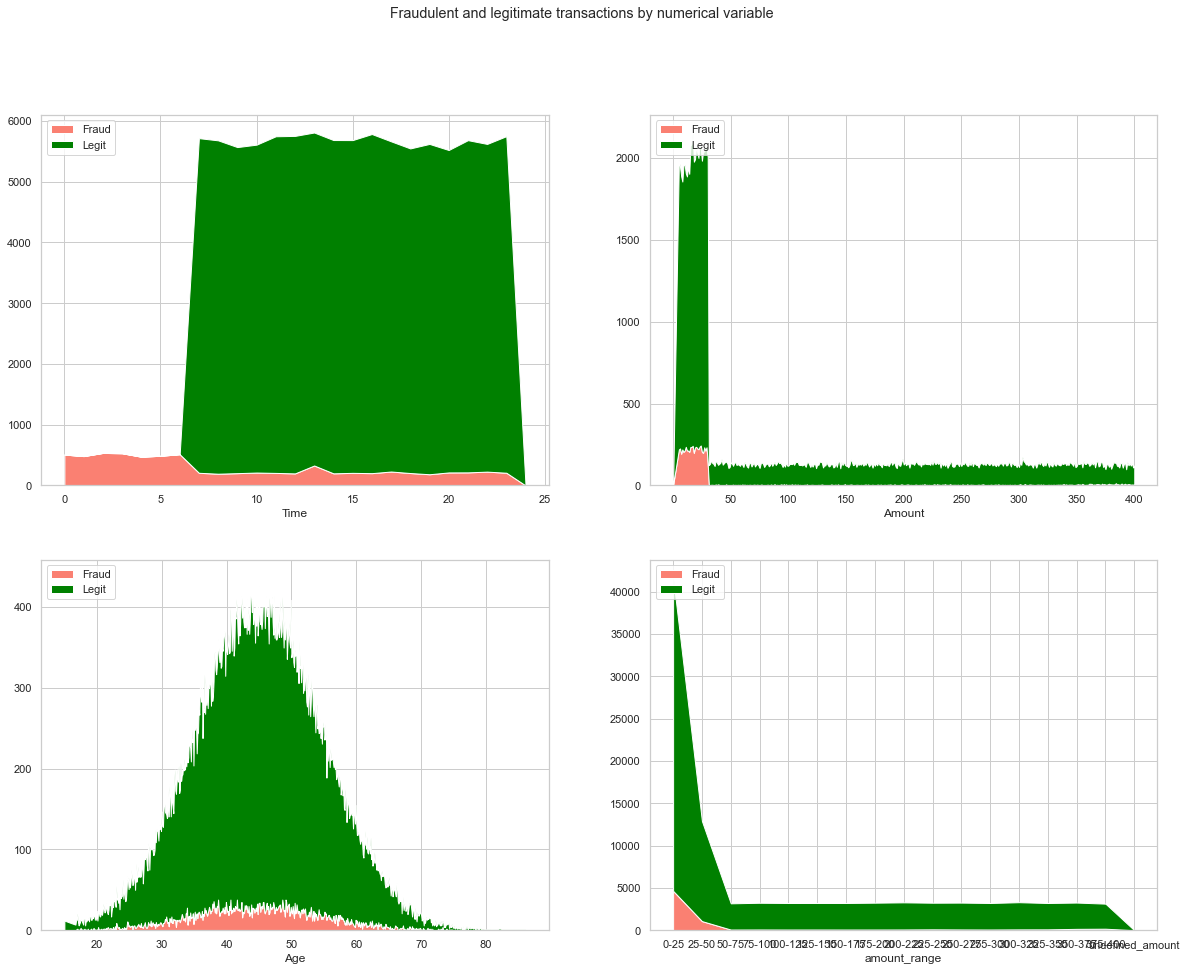

In [ ]:
df_num = df[['Time', 'Amount', 'Age', 'amount_range']]

i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(len(df_num.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 15))

for col in df_num:

    # create bar chart for each categorical variable

    group = df[[col, 'fraudulent', 'legit']]
    groupd = group.groupby(col).sum()
    x = groupd.index.values
    y_fraud = groupd.fraudulent
    y_legit = groupd.legit    
    labels = groupd.index.values
    legend = ['Fraud', 'Legit']
    # Basic stacked area chart.
    axs[i][j].stackplot(x,y_fraud, y_legit, labels=['Fraud', 'Legit'], colors=['salmon', 'green'])
    axs[i][j].legend(loc='upper left')
    axs[i][j].grid(True)
    axs[i][j].set_xlabel(col)
    #axs[i][j].set_xticklabels(labels=labels, rotation=45)
    axs[i][j].tick_params(axis='both', which='minor', labelsize=3)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.suptitle("Fraudulent and legitimate transactions by numerical variable", size='large')
plt.show()

It's very interesting to see how fraudulent transactions are distributed in terms of "time of the day" and "amount". All transactions occurring between midnight and ~6am and classified as fraudulent in this dataset. Additionally we can see that most fraudulent transactions involve low sums of money.

Let's repeat the exercise we did with categorical features and look at the 100% stacked view of numerical features.

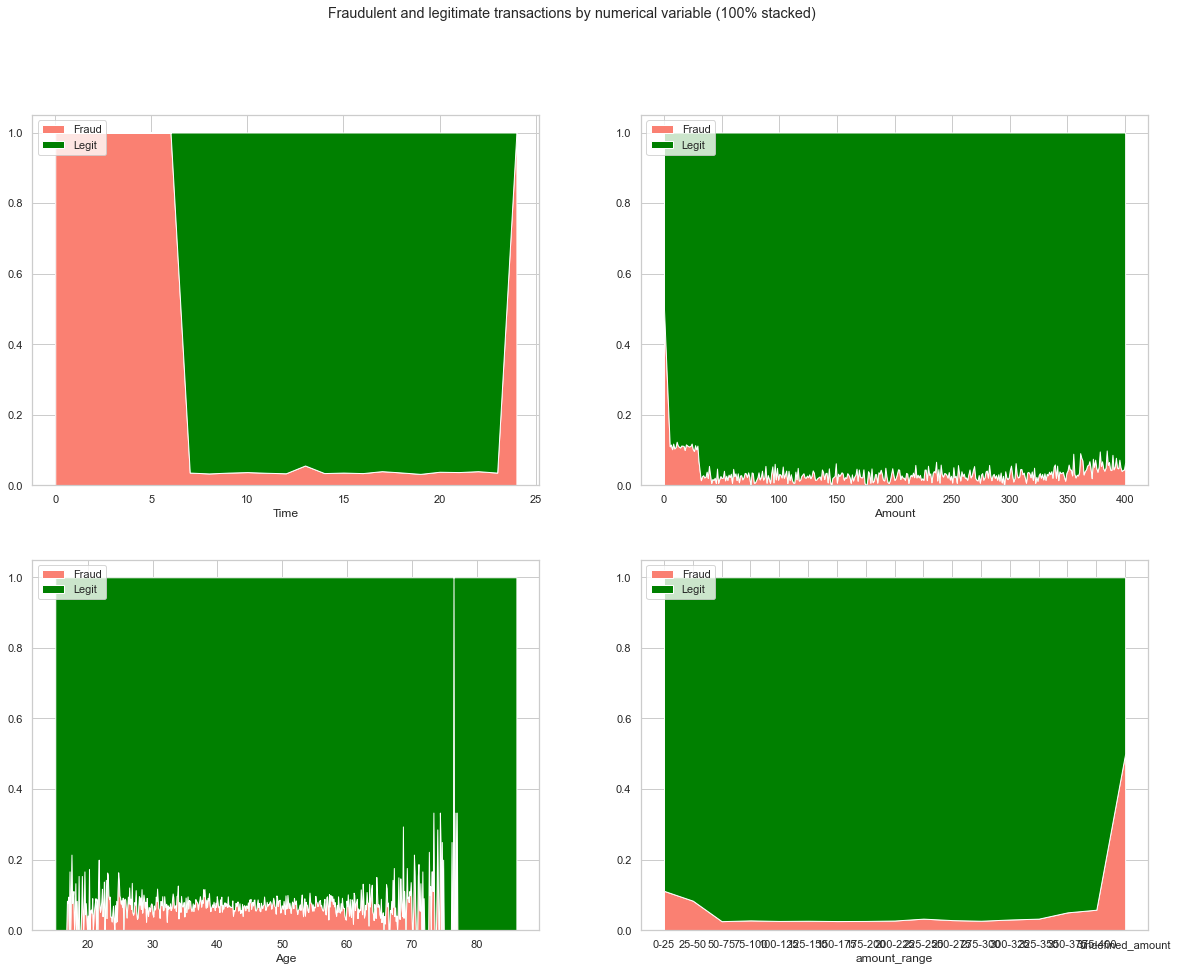

In [ ]:
# create the same view but with 100% stacked charts

numerical_columns = ['Time', 'Amount', 'Age', 'amount_range']

i,j=0,0
PLOTS_PER_ROW = 2
fig, axs = plt.subplots(math.ceil(len(numerical_columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 15))

for col in numerical_columns:

    # create bar chart for each categorical variable

    group = df[[col, 'fraudulent', 'legit']]
    groupd = group.groupby(col).sum()
    x = groupd.index.values
    y_fraud = groupd.fraudulent/(groupd.fraudulent+groupd.legit)
    y_legit = groupd.legit/(groupd.fraudulent+groupd.legit)
    labels = groupd.index.values
    legend = ['Fraud', 'Legit']
    # Basic stacked area chart.
    axs[i][j].stackplot(x,y_fraud, y_legit, labels=['Fraud', 'Legit'], colors=['salmon', 'green'])
    axs[i][j].legend(loc='upper left')
    axs[i][j].grid(True)
    axs[i][j].set_xlabel(col)
    #axs[i][j].set_xticklabels(labels=labels, rotation=45)
    axs[i][j].tick_params(axis='both', which='minor', labelsize=3)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
plt.suptitle("Fraudulent and legitimate transactions by numerical variable (100% stacked)", size='large')
plt.show()

This view has revelated a few more characteristics. For example we can see that actually there's an increase in the percentage of fraudulent transactions for amounts over £350. We can also see that transactions without any amount declared are fraudulent about 50% of the times.

Let's try to understand a bit better the distribution of legitimate and fraudulent transactions vs Amount by using a box plot.

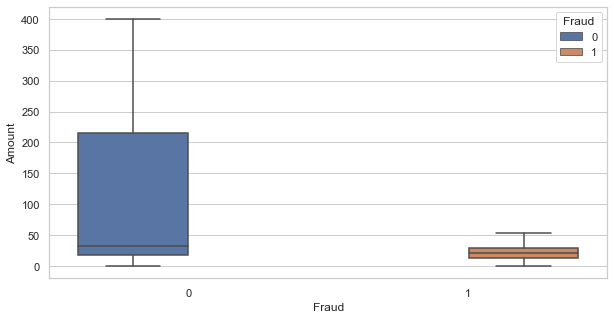

In [ ]:
# add box plot with distribution of amount by fraud/legit transactions, remove outliers

fig, ax = plt.subplots(figsize=(10,5))
sns.set_theme(style="whitegrid")
sns.boxplot(ax = ax, x='Fraud', y='Amount', hue='Fraud',data=df,showfliers=False)
plt.show()

As seen in the area charts, excluding outliers, the distribution of Amounts in fraudulent transactions is quite different to legitimate transactions. On average fraudulent transactions tend to take place with fairly small amounts. Almost 100% of transactions are under £50.

Finally let's look at the data imbalance to understand exactly what percentage of fraudulent and legitimate transactions we have.

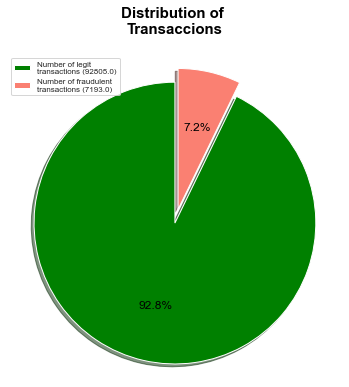

In [ ]:
# add pie chart with split of fraudulent vs legit transactions

fig, ax = plt.subplots(1,1, figsize=(6,6))

# Create a pieplot for x variable

x = df['legit'].sum()

y = df['fraudulent'].sum()

x_label = 'legit'

y_label = 'fraudulent'

values=[x, y]
labels = "Number of "+'{} '.format(x_label)+"\ntransactions ("+str(x)+")","Number of "+'{} '.format(y_label)+"\ntransactions ("+str(y)+")"
explode = (0, 0.1) # only explode the 2nd slice "No Approved"
colors = ['green', 'salmon']

ax.pie(values, explode=explode, colors=colors,
        shadow=True, startangle=90, autopct='%1.1f%%', textprops={'size':'medium', 'color' : 'black'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Distribution of \nTransaccions', fontsize=15, color='black', weight='bold', pad=20)
ax.legend(labels, loc='best', prop={'size': 8})
ax.axis('equal')
plt.show()


The dataset is imbalanced but there's still a significant representation of "fraudulent" transactions. Moreover, looking at the patterns in the charts for numerical variables we can clearly see that certain hours of the day and certain amounts are very likely to have a high percentage of fraudulent transactions.

Before we move on let's check for possible correlations among the numerical variables.

<AxesSubplot:>

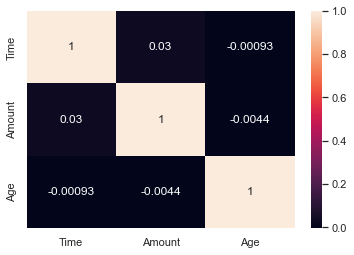

In [ ]:
sns.heatmap(df_num.corr(method='pearson'),annot=True)

There aren't any correlations between them.

# Feature engineering without oversampling and without normalisation

Before starting with feature engineering let's use scikit learn's train_test_split to split the data into train and test sets. We're doing so at this stage so as to avoid data lekeage, which occurs when information from the train dataset is leaked onto the test data set. 

The author won't discard any features at this point besides that ones that were created only for visualization purposes. It feels as though all of the features have small differences between them which could contribute to a better classification outcome. In other words, none of the features seem completely irrelevant.

In [ ]:
# split the data into training and test data sets

X = df[['Time','Type of Card','Entry Mode','Amount','Type of Transaction','Merchant Group','Bank','Country of Transaction',
       'Shipping Address','Country of Residence','Gender','Age','Day of the Week Reworked',
       'transaction_residence_relationship','residence_shipping_relationship','transaction_shipping_relationship']]

y = df['Fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50, stratify=df[["Fraud"]])

We'll define a function which we'll use moving forward for categorical feature encoding.

In [ ]:
# define one hot encoding function

def one_hot_sklearn(X_train, X_test, col):
    '''
    Function that OHE dataframe columns and returns encoded + original
    '''
    from sklearn.preprocessing import OneHotEncoder
    OHE = OneHotEncoder(handle_unknown='error', sparse=False) #removed the drop = 'first' condition
    if isinstance(col, list):
        cols = col 
    else:
        cols = [col]
    for c in cols:
        OHE_cols_train = pd.DataFrame(OHE.fit_transform(X_train[[c]]))
        OHE_cols_train.columns = OHE.get_feature_names_out([c])
        OHE_cols_test = pd.DataFrame(OHE.transform(X_test[[c]]))
        OHE_cols_test.columns = OHE.get_feature_names_out([c])
        OHE_cols_train.index = X_train.index
        OHE_cols_test.index = X_test.index
        X_train = pd.concat([X_train, OHE_cols_train], axis=1).drop(columns=c)  
        X_test = pd.concat([X_test, OHE_cols_test], axis=1).drop(columns=c) 
  
    return X_train, X_test

And we'll run one hot encoding for all categorical variables across the test and train data sets.

In [ ]:
#run one hot encoding

cat_variables = ['Type of Card','Entry Mode','Type of Transaction','Merchant Group','Bank','Country of Transaction',
       'Shipping Address','Country of Residence','Gender','Day of the Week Reworked']

X_train, X_test = one_hot_sklearn(X_train, X_test, cat_variables)

X_test.head()

,Time,Amount,Age,transaction_residence_relationship,residence_shipping_relationship,transaction_shipping_relationship,Type of Card_MasterCard,Type of Card_Visa,Entry Mode_CVC,Entry Mode_PIN,...,Country of Residence_China,Country of Residence_India,Country of Residence_Russia,Country of Residence_USA,Country of Residence_United Kingdom,Gender_F,Gender_M,Gender_undefined_gender,Day of the Week Reworked_Tuesday,Day of the Week Reworked_Wednesday
95866,16,18.0,53.2,1,1,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
10738,18,17.0,51.5,0,0,1,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
70463,19,28.0,21.3,1,1,1,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
82255,10,22.0,45.5,1,1,1,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
80677,3,202.0,43.6,0,0,1,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


# Model training without feature engineering or hyperparameter tunning 

At this stage we're ready to start training some classifier algorithms with the training data set. I'll start training them with minimal intervention of both the feature engineering side as well as the algorithm tunning side. We'll use the results from this first run as the baseline for future optimisation.

To start training the classifiers let's create a dictionary which instantiates each of the classifier we're going to use.

After that, let's go ahead and fit each of the classifers to the training data set using a for loop.

In [ ]:
# create a "classifiers" dictionary and loop through it to train each of the classifiers within

classifiers = {"Logistic Regression":LogisticRegression(max_iter = 1000), 
               "Decision Tree": DecisionTreeClassifier(), 
               "Bagging Classifier" : BaggingClassifier(),
               "Random Forest": RandomForestClassifier(), 
               "Ada Boost Classifier": AdaBoostClassifier(),
               "XGBoost Classifier": xgb.XGBClassifier()}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)

We have trained our first 6 models. That was quick! Let's look at the results of each of these algorithms by plotting a series of confusion matrices which will show the True Negatives, False Positives, False Negatives and True Positives.

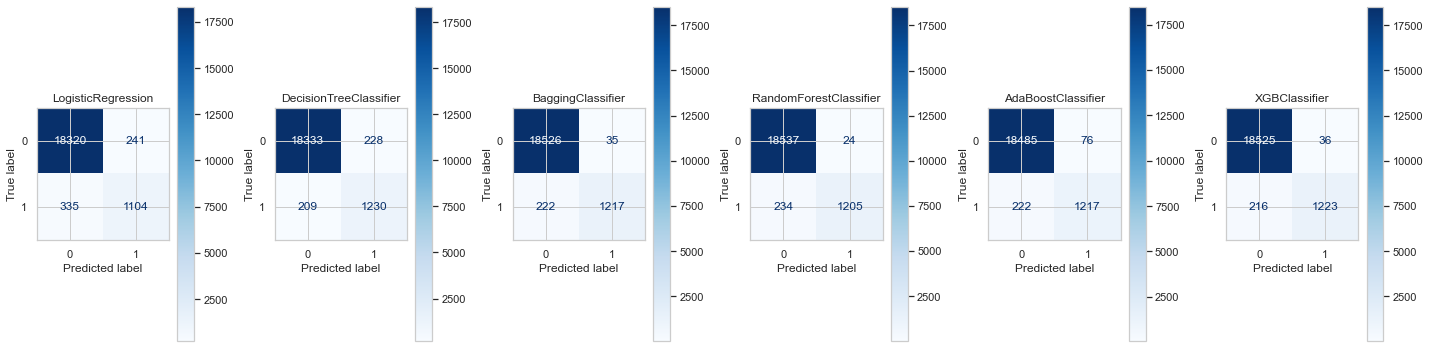

In [ ]:
# create subplot and iterate over the classifiers and axes

from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=len(classifiers.keys()), figsize=(20,5))

for classifier, ax in zip(classifiers.values(), axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(classifier, 
                                          X_test, 
                                          y_test, 
                                          ax=ax, 
                                          cmap='Blues')
    ax.title.set_text(type(classifier).__name__)
plt.tight_layout()  
plt.show()

We can see that all algorithms are very good at predicting negative instances. In other words they are very good at predicting legitimate transactions which are the vast majority of transactions in the dataset (>90%). From this view though, it's not easy to compare performance across all algorithms so let's try to plot different performance metrics in a table.

In [ ]:
#create df for results

results_df = pd.DataFrame(index=['F1', 'Recall', 'Precision', 'Accuracy Score', 'ROC AUC','LogLoss','Correct_Predictions','Incorrect_Predictions'], 
                         columns = ['Logistic Regression', 'Decision Tree', 'Bagging Classifier',
                                   'Random Forest','Ada Boost Classifier','XGBoost Classifier','NeuralNetwork'])

results_df.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recall,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precision,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC AUC,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogLoss,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#calculate predictions and probabilities and store results in a df

for classifier, key in zip(classifiers.values(),classifiers.keys()):
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)
    f1 = round(f1_score(y_test,y_pred),3)
    recall = round(recall_score(y_test,y_pred),3)
    precision = round(precision_score(y_test,y_pred),3)
    accuracy = round(accuracy_score(y_test,y_pred),3)
    rocauc = round(roc_auc_score(y_test,y_pred),3)
    logloss = round(log_loss(y_test, y_prob),3)
    Correct_Predictions = int(accuracy * len(y_test))
    Incorrect_Predictions = int(len(y_test) - (accuracy * len(y_test)))
    results_df[key] = ([f1, recall, precision, accuracy, rocauc, logloss, Correct_Predictions,Incorrect_Predictions])

results_df.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1,0.793,0.849,0.904,0.903,0.891,0.907,NaN
Recall,0.767,0.855,0.846,0.837,0.846,0.850,NaN
Precision,0.821,0.844,0.972,0.980,0.941,0.971,NaN
Accuracy Score,0.971,0.978,0.987,0.987,0.985,0.987,NaN
ROC AUC,0.877,0.921,0.922,0.918,0.921,0.924,NaN
LogLoss,0.069,0.755,0.149,0.051,0.589,0.042,NaN


This table makes it easier to compare. As I mentioned, all algorithms have a high accuracy thanks to the fact that they classify very well negative instances (legitimate transactions) but they don't do so well in classifying positive instances (fraudulent transactions). The poorer classification of fraudulent transactions in the test dateset is reflected in the Recall which measures the % of true positives correctly identified by each algorithm. 

In order to bring all of those metrics together we're going to focus on the ROC AUC score which combines the "True Positive Rate" (TPR) and "False Positive Rate" (FPR). A model that classifies all the observations correctly would have a ROC AUC Score of 1, therefore the closer the ROC AUC Score to 1 the better. This is the metric we're going to use moving forward to score all algorithms.

Now let's train an Artificial Neural Network with the same data

In [ ]:
# Model Hyperparameters

neurons = 16
epochs = 100

#instantiate the model

model_nn = tf.keras.Sequential([
                             tf.keras.layers.Dense(neurons, activation='relu', input_shape=(X_train.shape[-1],)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

model_nn.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives',
                       'FalsePositives', 'FalseNegatives'])

In [ ]:
r = model_nn.fit(X_train, y_train, epochs=epochs, verbose=2, 
                 validation_data=(X_test, y_test), shuffle=True)

Epoch 1/100
2500/2500 - 5s - loss: 0.4453 - accuracy: 0.9326 - auc: 0.8474 - precision: 0.5452 - recall: 0.3770 - true_negatives: 72435.0000 - true_positives: 2169.0000 - false_positives: 1809.0000 - false_negatives: 3585.0000 - val_loss: 0.0932 - val_accuracy: 0.9704 - val_auc: 0.9691 - val_precision: 0.9308 - val_recall: 0.6359 - val_true_negatives: 18493.0000 - val_true_positives: 915.0000 - val_false_positives: 68.0000 - val_false_negatives: 524.0000 - 5s/epoch - 2ms/step
Epoch 2/100
2500/2500 - 3s - loss: 0.0955 - accuracy: 0.9638 - auc: 0.9698 - precision: 0.8574 - recall: 0.5956 - true_negatives: 73674.0000 - true_positives: 3427.0000 - false_positives: 570.0000 - false_negatives: 2327.0000 - val_loss: 0.0699 - val_accuracy: 0.9770 - val_auc: 0.9812 - val_precision: 0.9283 - val_recall: 0.7373 - val_true_negatives: 18479.0000 - val_true_positives: 1061.0000 - val_false_positives: 82.0000 - val_false_negatives: 378.0000 - 3s/epoch - 1ms/step
Epoch 3/100
2500/2500 - 3s - loss: 0.0

Epoch 18/100
2500/2500 - 3s - loss: 0.0804 - accuracy: 0.9671 - auc: 0.9783 - precision: 0.9278 - recall: 0.5878 - true_negatives: 73981.0000 - true_positives: 3382.0000 - false_positives: 263.0000 - false_negatives: 2372.0000 - val_loss: 0.0596 - val_accuracy: 0.9773 - val_auc: 0.9872 - val_precision: 0.9370 - val_recall: 0.7338 - val_true_negatives: 18490.0000 - val_true_positives: 1056.0000 - val_false_positives: 71.0000 - val_false_negatives: 383.0000 - 3s/epoch - 1ms/step
Epoch 19/100
2500/2500 - 2s - loss: 0.0803 - accuracy: 0.9679 - auc: 0.9789 - precision: 0.9318 - recall: 0.5982 - true_negatives: 73992.0000 - true_positives: 3442.0000 - false_positives: 252.0000 - false_negatives: 2312.0000 - val_loss: 0.0583 - val_accuracy: 0.9794 - val_auc: 0.9874 - val_precision: 0.9298 - val_recall: 0.7728 - val_true_negatives: 18477.0000 - val_true_positives: 1112.0000 - val_false_positives: 84.0000 - val_false_negatives: 327.0000 - 2s/epoch - 954us/step
Epoch 20/100
2500/2500 - 2s - loss

Epoch 35/100
2500/2500 - 2s - loss: 0.0763 - accuracy: 0.9706 - auc: 0.9792 - precision: 0.9342 - recall: 0.6361 - true_negatives: 73986.0000 - true_positives: 3660.0000 - false_positives: 258.0000 - false_negatives: 2094.0000 - val_loss: 0.0623 - val_accuracy: 0.9786 - val_auc: 0.9829 - val_precision: 0.9591 - val_recall: 0.7338 - val_true_negatives: 18516.0000 - val_true_positives: 1056.0000 - val_false_positives: 45.0000 - val_false_negatives: 383.0000 - 2s/epoch - 979us/step
Epoch 36/100
2500/2500 - 2s - loss: 0.0771 - accuracy: 0.9707 - auc: 0.9795 - precision: 0.9327 - recall: 0.6387 - true_negatives: 73979.0000 - true_positives: 3675.0000 - false_positives: 265.0000 - false_negatives: 2079.0000 - val_loss: 0.0564 - val_accuracy: 0.9795 - val_auc: 0.9877 - val_precision: 0.9486 - val_recall: 0.7561 - val_true_negatives: 18502.0000 - val_true_positives: 1088.0000 - val_false_positives: 59.0000 - val_false_negatives: 351.0000 - 2s/epoch - 959us/step
Epoch 37/100
2500/2500 - 2s - lo

Epoch 52/100
2500/2500 - 2s - loss: 0.0740 - accuracy: 0.9714 - auc: 0.9803 - precision: 0.9350 - recall: 0.6475 - true_negatives: 73985.0000 - true_positives: 3726.0000 - false_positives: 259.0000 - false_negatives: 2028.0000 - val_loss: 0.0561 - val_accuracy: 0.9802 - val_auc: 0.9881 - val_precision: 0.9328 - val_recall: 0.7811 - val_true_negatives: 18480.0000 - val_true_positives: 1124.0000 - val_false_positives: 81.0000 - val_false_negatives: 315.0000 - 2s/epoch - 964us/step
Epoch 53/100
2500/2500 - 2s - loss: 0.0757 - accuracy: 0.9712 - auc: 0.9800 - precision: 0.9350 - recall: 0.6449 - true_negatives: 73986.0000 - true_positives: 3711.0000 - false_positives: 258.0000 - false_negatives: 2043.0000 - val_loss: 0.0588 - val_accuracy: 0.9808 - val_auc: 0.9850 - val_precision: 0.9459 - val_recall: 0.7769 - val_true_negatives: 18497.0000 - val_true_positives: 1118.0000 - val_false_positives: 64.0000 - val_false_negatives: 321.0000 - 2s/epoch - 944us/step
Epoch 54/100
2500/2500 - 2s - lo

Epoch 69/100
2500/2500 - 2s - loss: 0.0757 - accuracy: 0.9715 - auc: 0.9789 - precision: 0.9375 - recall: 0.6463 - true_negatives: 73996.0000 - true_positives: 3719.0000 - false_positives: 248.0000 - false_negatives: 2035.0000 - val_loss: 0.0589 - val_accuracy: 0.9797 - val_auc: 0.9858 - val_precision: 0.9559 - val_recall: 0.7526 - val_true_negatives: 18511.0000 - val_true_positives: 1083.0000 - val_false_positives: 50.0000 - val_false_negatives: 356.0000 - 2s/epoch - 984us/step
Epoch 70/100
2500/2500 - 3s - loss: 0.0751 - accuracy: 0.9718 - auc: 0.9793 - precision: 0.9422 - recall: 0.6484 - true_negatives: 74015.0000 - true_positives: 3731.0000 - false_positives: 229.0000 - false_negatives: 2023.0000 - val_loss: 0.0595 - val_accuracy: 0.9792 - val_auc: 0.9852 - val_precision: 0.9571 - val_recall: 0.7443 - val_true_negatives: 18513.0000 - val_true_positives: 1071.0000 - val_false_positives: 48.0000 - val_false_negatives: 368.0000 - 3s/epoch - 1ms/step
Epoch 71/100
2500/2500 - 2s - loss

Epoch 86/100
2500/2500 - 2s - loss: 0.0758 - accuracy: 0.9714 - auc: 0.9791 - precision: 0.9423 - recall: 0.6411 - true_negatives: 74018.0000 - true_positives: 3689.0000 - false_positives: 226.0000 - false_negatives: 2065.0000 - val_loss: 0.0584 - val_accuracy: 0.9791 - val_auc: 0.9872 - val_precision: 0.9294 - val_recall: 0.7686 - val_true_negatives: 18477.0000 - val_true_positives: 1106.0000 - val_false_positives: 84.0000 - val_false_negatives: 333.0000 - 2s/epoch - 976us/step
Epoch 87/100
2500/2500 - 3s - loss: 0.0754 - accuracy: 0.9719 - auc: 0.9789 - precision: 0.9381 - recall: 0.6529 - true_negatives: 73996.0000 - true_positives: 3757.0000 - false_positives: 248.0000 - false_negatives: 1997.0000 - val_loss: 0.0598 - val_accuracy: 0.9796 - val_auc: 0.9849 - val_precision: 0.9518 - val_recall: 0.7547 - val_true_negatives: 18506.0000 - val_true_positives: 1086.0000 - val_false_positives: 55.0000 - val_false_negatives: 353.0000 - 3s/epoch - 1ms/step
Epoch 88/100
2500/2500 - 3s - loss

In [ ]:
# Convert all the outputs to booleans (just makes it easier to see)
threshold = 0.5

y_pred = model_nn.predict(X_test)
y_pred = y_pred > threshold
y_test = y_test > threshold

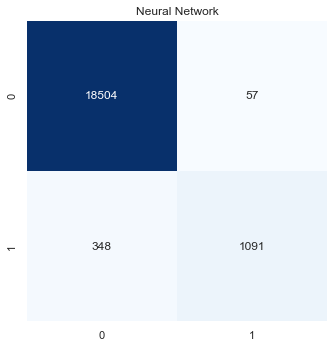

In [ ]:
# create subplot and iterate over the classifiers and axes

from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat, square=True, cmap="Blues", annot=True, fmt='d', cbar=False)
ax.title.set_text("Neural Network")
plt.tight_layout()  
plt.show()

In [ ]:
# accuracy metrics

y_test = y_test.astype(int)
y_pred = y_pred.astype(int)


f1 = round(f1_score(y_test,y_pred),3)
recall = round(recall_score(y_test,y_pred),3)
precision = round(precision_score(y_test,y_pred),3)
accuracy = round(accuracy_score(y_test,y_pred),3)
rocauc = round(roc_auc_score(y_test,y_pred),3)
logloss = 0.060
Correct_Predictions = int(accuracy * len(y_test))
Incorrect_Predictions = int(len(y_test) - (accuracy * len(y_test)))

results_df['NeuralNetwork'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions,Incorrect_Predictions])

results_df.head(8)


,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1,0.793,0.849,0.904,0.903,0.891,0.907,0.843
Recall,0.767,0.855,0.846,0.837,0.846,0.850,0.758
Precision,0.821,0.844,0.972,0.980,0.941,0.971,0.950
Accuracy Score,0.971,0.978,0.987,0.987,0.985,0.987,0.980
ROC AUC,0.877,0.921,0.922,0.918,0.921,0.924,0.878
LogLoss,0.069,0.755,0.149,0.051,0.589,0.042,0.060
Correct_Predictions,19420.000,19560.000,19740.000,19740.000,19700.000,19740.000,19600.000
Incorrect_Predictions,580.000,440.000,260.000,260.000,300.000,260.000,400.000


Before we continue let's look at a brief description of how each model works and their strenghts and weaknesses so that we can understand better how to optimise them further. 

**Logistic Regression**
- Brief Description: generates predictions from 0 to 1. If the value of a prediction is equal or bigger than 0.5 it is classified as belonging to class 1 whilst below 0.5 it is classified as belonging to 0. It learns a linear relationship between independent and dependent variables.
- Strengths: easy to interpret and visualise results and fast to train. Performs well when results are linearly separable. 
- Limitations: it’s a linear classifier and so in order to perform well it needs some sort of linear relationship in the data.  
(Hosmer et al, 2013)

**Decision Tree Classifier**
- Brief Description: simplest form of tree algorithm which works as the basis for other three algorithms (Random Forest, Adaboost). It helps classify observations based on different rules which divide the dataset into always smaller subsets. 
- Strengths: Extremely easy to visualise particularly in trees with not much depth. It doesn’t require much data preparation (normalisation or scaling).
- Limitations: Trees with a lot of depth might tend to overfitting and therefore won’t generalise well. It doesn’t perform well when there's a linear relationship between independent and dependent variables and it can be quite expensive to train.
(Jolly, 2018)

**Bagging Classifier**
- Brief Description: it’s an ensemble algorithm which combines different weak models to produce a stronger combined model. The default base model for bagging classifier is a decision tree. It works by fitting the base model in different subsets of the original training set and then aggregates the results of each subset to produce a final stronger algorithm.
- Strengths: it shares some strengths with the decision tree given that the base model is in fact a decision tree. Therefore it doesn’t require much data preparation in the form of normalisation or scaling. Because it’s trained on different subsets of data it tends to produce results that generalise better than with a simple decision tree. There’s less tendency to overfitting.
- Limitations: the final prediction of a bagging classifier is based on either the most voted class or the highest average of all classes in the model instead of the actual output values from each classification model. This can lead to less accurate models.

**Random Forest Classifier**
- Brief Description: it’s another form of ensemble algorithm which makes use of multiple models to arrive at an outcome. Random forest picks a portion of the features and builds a decision tree off of that. It then continues building decision trees with the remaining features. Eventually the class with the most votes across all models will be the final prediction.
- Strengths: It reduces the impact of overfitting in decision trees and therefore generalises better in the test dataset. Because it’s a tree based model it also requires less data preparation (normalisation and scaling).
- Limitations: it is computationally expensive to train given that it has to build many individual trees and combine all of them to arrive at a final decision. 
(Jolly, 2018)


**AdaBoost Classifier**
- Brief Description: it’s another form of ensemble algorithm which uses a “boosting” technique rather than a “bagging” technique. What this means in the case of AdaBoost is that it will build an initial base estimator using a decision tree, and then it will build subsequent estimators based on the results of that initial estimator. The main difference with a bagging algorithm is that the process of building different estimators takes place sequentially and each prior estimator feeds into the next one. In a bagging classifier such as a random forest, the process of building different estimators takes place in parallel and estimators are independent of each other. Another important difference in boosting algorithms is that each of the estimators will have different weights (different levels of importance) in the final prediction. With AdaBoost in particular it’s also relevant to note that each decision tree will be limited to a depth of 1, with one root and 2 leafs. At each model iteration misclassified instances will be given more importance than correctly classified instances. 
- Strengths: The boosting technique leads to less overfitting than other tree-based algorithms and therefore it generalises better. 
- Limitations: Because we’re dealing with a tree-based boosting algorithm, outliers may reduce the accuracy of the model produced. 
(Jolly, 2018)

**XGBoost**
- Brief Description: is another ensemble algorithm which combines the power of several weaker models to produce a final stronger model using a “boosting” technique (same as with AdaBoost). XGBoost in this case is an extreme version of Gradient Boosting. Gradient boosting combines different weak decision trees which are built sequentially. With extreme Gradient Boosting in each step the algorithm calculates the residuals and a regularisation parameter which feed into the next tree. 
- Strengths: The residuals and regularisation parameter prevent the final model from overfitting so it generalises better than a simple decision tree or a Gradient Boosting algorithm. XGBoost is also more computationally efficient than Gradient Boosting. 
- Limitations: It can be slower to run than other boosting algorithms if there are a lot of features fed to the model. 
(Wade & Glynn, 2020)

**Artificial Neural Network**
- Brief Description: deep learning is a type of machine learning that involves algorithms with a structure inspired on the function of the brain. Neural networks are a type of deep learning algorithms that have an input layer with several nodes, an output layer with the final prediction and normally one or several hidden layers. For each hidden node the algorithm will calculate an output based on the input layers and the defined activation function. It will do this repetitively across as many layers as defined in the design phase until it reaches a final outcome in the output layer.
- Strengths: Neural networks can become very good at understanding the relationship between all the features and can work well establishing relationships between non-linear variables. 
- Limitations: Neural networks require larger datasets than other non deep learning algorithms. They also use significantly more computational resources to train and are also slower to run. 
(Ng, A 2020)


# Model training with feature engineering

Now let's run again the same model but changing numerical features so that they are all zero-centered. We'll then be able to measure if there's any improvements in performance. Let's also check that after the change the % of positive instances in the test and train data set remain balanced.

In [ ]:
# normalize Amount, time, and age which as previously said didn't have the mean zero_centered

X_train_norm = X_train.copy()

X_train_norm["Time"] = X_train["Time"].subtract(X_train["Time"].mean())
X_train_norm["Amount"] = X_train["Amount"].subtract(X_train["Amount"].mean())
X_train_norm["Age"] = X_train["Age"].subtract(X_train["Age"].mean())

X_test_norm = X_test.copy()

X_test_norm["Time"] = X_test["Time"].subtract(X_test["Time"].mean())
X_test_norm["Amount"] = X_test["Amount"].subtract(X_test["Amount"].mean())
X_test_norm["Age"] = X_test["Age"].subtract(X_test["Age"].mean())

train_value_counts = y_train.value_counts()
print("Fraudulent transactions are %.2f%% of the training set." % (train_value_counts[1] * 100 / len(y_train)))
test_value_counts = y_test.value_counts()
print("Fraudulent transactions are %.2f%% of the test set." % (test_value_counts[1] * 100 / len(y_test)))

Fraudulent transactions are 7.19% of the training set.
Fraudulent transactions are 7.20% of the test set.


Let's instantiate the classifiers again but this time let's train them with the normalised dataset.

In [ ]:
# create a "classifiers" dictionary and loop through it to train each of the classifiers within

classifiers = {"Logistic Regression":LogisticRegression(max_iter = 1000), 
               "Decision Tree": DecisionTreeClassifier(), 
               "Bagging Classifier" : BaggingClassifier(),
               "Random Forest": RandomForestClassifier(), 
               "Ada Boost Classifier": AdaBoostClassifier(),
               "XGBoost Classifier": xgb.XGBClassifier()}

for key, classifier in classifiers.items():
    classifier.fit(X_train_norm, y_train)

And evaluate the performance looking at the confusion matrices and scores table.

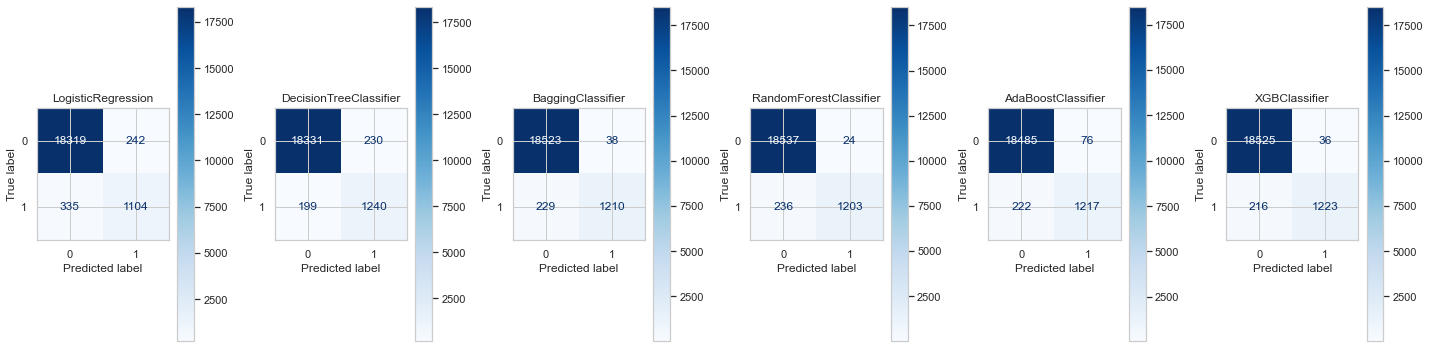

In [ ]:
# create subplot and iterate over the classifiers and axes

from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=len(classifiers.keys()), figsize=(20,5))

for classifier, ax in zip(classifiers.values(), axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(classifier, 
                                          X_test_norm, 
                                          y_test, 
                                          ax=ax, 
                                          cmap='Blues')
    ax.title.set_text(type(classifier).__name__)
plt.tight_layout()  
plt.show()

In [ ]:
#create df for results

results_df_norm = pd.DataFrame(index=['F1_norm', 'Recall_norm', 'Precision_norm', 'Accuracy Score_norm', 'ROC AUC_norm','LogLoss_norm','Correct_Predictions_norm','Incorrect_Predictions_norm'], 
                         columns = ['Logistic Regression', 'Decision Tree', 'Bagging Classifier',
                                   'Random Forest','Ada Boost Classifier','XGBoost Classifier','NeuralNetwork'])

results_df_norm.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recall_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precision_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy Score_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC AUC_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogLoss_norm,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#calculate predictions and probabilities and store results in a df

for classifier, key in zip(classifiers.values(),classifiers.keys()):
    y_pred = classifier.predict(X_test_norm)
    y_prob = classifier.predict_proba(X_test_norm)
    f1_norm = round(f1_score(y_test,y_pred),3)
    recall_norm = round(recall_score(y_test,y_pred),3)
    precision_norm = round(precision_score(y_test,y_pred),3)
    accuracy_norm = round(accuracy_score(y_test,y_pred),3)
    rocauc_norm = round(roc_auc_score(y_test,y_pred),3)
    logloss_norm = round(log_loss(y_test, y_prob),3)
    Correct_Predictions_norm = int(accuracy_norm * len(y_test))
    Incorrect_Predictions_norm = int(len(y_test) - (accuracy_norm * len(y_test)))
    results_df_norm[key] = ([f1_norm, recall_norm, precision_norm, accuracy_norm, rocauc_norm, logloss_norm,Correct_Predictions_norm,Incorrect_Predictions_norm])

results_df_norm.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_norm,0.793,0.853,0.901,0.902,0.891,0.907,NaN
Recall_norm,0.767,0.862,0.841,0.836,0.846,0.850,NaN
Precision_norm,0.820,0.844,0.970,0.980,0.941,0.971,NaN
Accuracy Score_norm,0.971,0.979,0.987,0.987,0.985,0.987,NaN
ROC AUC_norm,0.877,0.925,0.919,0.917,0.921,0.924,NaN
LogLoss_norm,0.069,0.741,0.154,0.054,0.589,0.042,NaN
Correct_Predictions_norm,19420.000,19580.000,19740.000,19740.000,19700.000,19740.000,NaN
Incorrect_Predictions_norm,580.000,420.000,260.000,260.000,300.000,260.000,NaN


In [ ]:
results_df.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1,0.793,0.849,0.904,0.903,0.891,0.907,0.843
Recall,0.767,0.855,0.846,0.837,0.846,0.850,0.758
Precision,0.821,0.844,0.972,0.980,0.941,0.971,0.950
Accuracy Score,0.971,0.978,0.987,0.987,0.985,0.987,0.980
ROC AUC,0.877,0.921,0.922,0.918,0.921,0.924,0.878
LogLoss,0.069,0.755,0.149,0.051,0.589,0.042,0.060
Correct_Predictions,19420.000,19560.000,19740.000,19740.000,19700.000,19740.000,19600.000
Incorrect_Predictions,580.000,440.000,260.000,260.000,300.000,260.000,400.000


Normalising the numerical features so that they are zero-centered has not provided any improvements in performance measured in ROC AUC and has only provided very small improvements in recall. Because the score have not decrease we'll keep it for now.

Now let's repeat the same for the Neural Network classifier

In [ ]:
# Model Hyperparameters

neurons = 16
epochs = 100

#instantiate the model

model_nn = tf.keras.Sequential([
                             tf.keras.layers.Dense(neurons, activation='relu', input_shape=(X_train_norm.shape[-1],)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

model_nn.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives',
                       'FalsePositives', 'FalseNegatives'])

In [ ]:
r = model_nn.fit(X_train_norm, y_train, epochs=epochs, verbose=2, 
                 validation_data=(X_test_norm, y_test), shuffle=True)


Epoch 1/100
2500/2500 - 4s - loss: 0.1853 - accuracy: 0.9502 - auc: 0.9073 - precision: 0.6975 - recall: 0.5429 - true_negatives: 72889.0000 - true_positives: 3124.0000 - false_positives: 1355.0000 - false_negatives: 2630.0000 - val_loss: 0.0651 - val_accuracy: 0.9759 - val_auc: 0.9863 - val_precision: 0.8667 - val_recall: 0.7860 - val_true_negatives: 18387.0000 - val_true_positives: 1131.0000 - val_false_positives: 174.0000 - val_false_negatives: 308.0000 - 4s/epoch - 2ms/step
Epoch 2/100
2500/2500 - 2s - loss: 0.0762 - accuracy: 0.9717 - auc: 0.9805 - precision: 0.8685 - recall: 0.7148 - true_negatives: 73621.0000 - true_positives: 4113.0000 - false_positives: 623.0000 - false_negatives: 1641.0000 - val_loss: 0.0612 - val_accuracy: 0.9767 - val_auc: 0.9874 - val_precision: 0.8804 - val_recall: 0.7825 - val_true_negatives: 18408.0000 - val_true_positives: 1126.0000 - val_false_positives: 153.0000 - val_false_negatives: 313.0000 - 2s/epoch - 987us/step
Epoch 3/100
2500/2500 - 2s - loss

Epoch 18/100
2500/2500 - 3s - loss: 0.0677 - accuracy: 0.9747 - auc: 0.9852 - precision: 0.8988 - recall: 0.7301 - true_negatives: 73771.0000 - true_positives: 4201.0000 - false_positives: 473.0000 - false_negatives: 1553.0000 - val_loss: 0.0578 - val_accuracy: 0.9801 - val_auc: 0.9891 - val_precision: 0.9000 - val_recall: 0.8131 - val_true_negatives: 18431.0000 - val_true_positives: 1170.0000 - val_false_positives: 130.0000 - val_false_negatives: 269.0000 - 3s/epoch - 1ms/step
Epoch 19/100
2500/2500 - 2s - loss: 0.0674 - accuracy: 0.9758 - auc: 0.9860 - precision: 0.9062 - recall: 0.7400 - true_negatives: 73803.0000 - true_positives: 4258.0000 - false_positives: 441.0000 - false_negatives: 1496.0000 - val_loss: 0.0561 - val_accuracy: 0.9808 - val_auc: 0.9891 - val_precision: 0.9067 - val_recall: 0.8172 - val_true_negatives: 18440.0000 - val_true_positives: 1176.0000 - val_false_positives: 121.0000 - val_false_negatives: 263.0000 - 2s/epoch - 974us/step
Epoch 20/100
2500/2500 - 2s - lo

Epoch 35/100
2500/2500 - 2s - loss: 0.0692 - accuracy: 0.9749 - auc: 0.9847 - precision: 0.8992 - recall: 0.7336 - true_negatives: 73771.0000 - true_positives: 4221.0000 - false_positives: 473.0000 - false_negatives: 1533.0000 - val_loss: 0.0568 - val_accuracy: 0.9804 - val_auc: 0.9891 - val_precision: 0.9266 - val_recall: 0.7894 - val_true_negatives: 18471.0000 - val_true_positives: 1136.0000 - val_false_positives: 90.0000 - val_false_negatives: 303.0000 - 2s/epoch - 940us/step
Epoch 36/100
2500/2500 - 2s - loss: 0.0683 - accuracy: 0.9751 - auc: 0.9853 - precision: 0.9042 - recall: 0.7315 - true_negatives: 73798.0000 - true_positives: 4209.0000 - false_positives: 446.0000 - false_negatives: 1545.0000 - val_loss: 0.0584 - val_accuracy: 0.9788 - val_auc: 0.9890 - val_precision: 0.9037 - val_recall: 0.7894 - val_true_negatives: 18440.0000 - val_true_positives: 1136.0000 - val_false_positives: 121.0000 - val_false_negatives: 303.0000 - 2s/epoch - 925us/step
Epoch 37/100
2500/2500 - 2s - l

Epoch 52/100
2500/2500 - 2s - loss: 0.0684 - accuracy: 0.9757 - auc: 0.9849 - precision: 0.9022 - recall: 0.7435 - true_negatives: 73780.0000 - true_positives: 4278.0000 - false_positives: 464.0000 - false_negatives: 1476.0000 - val_loss: 0.0577 - val_accuracy: 0.9809 - val_auc: 0.9881 - val_precision: 0.9120 - val_recall: 0.8138 - val_true_negatives: 18448.0000 - val_true_positives: 1171.0000 - val_false_positives: 113.0000 - val_false_negatives: 268.0000 - 2s/epoch - 964us/step
Epoch 53/100
2500/2500 - 2s - loss: 0.0687 - accuracy: 0.9749 - auc: 0.9849 - precision: 0.9004 - recall: 0.7320 - true_negatives: 73778.0000 - true_positives: 4212.0000 - false_positives: 466.0000 - false_negatives: 1542.0000 - val_loss: 0.0602 - val_accuracy: 0.9789 - val_auc: 0.9888 - val_precision: 0.8820 - val_recall: 0.8151 - val_true_negatives: 18404.0000 - val_true_positives: 1173.0000 - val_false_positives: 157.0000 - val_false_negatives: 266.0000 - 2s/epoch - 937us/step
Epoch 54/100
2500/2500 - 2s - 

Epoch 69/100
2500/2500 - 2s - loss: 0.0686 - accuracy: 0.9755 - auc: 0.9843 - precision: 0.9023 - recall: 0.7398 - true_negatives: 73783.0000 - true_positives: 4257.0000 - false_positives: 461.0000 - false_negatives: 1497.0000 - val_loss: 0.0562 - val_accuracy: 0.9798 - val_auc: 0.9892 - val_precision: 0.9238 - val_recall: 0.7839 - val_true_negatives: 18468.0000 - val_true_positives: 1128.0000 - val_false_positives: 93.0000 - val_false_negatives: 311.0000 - 2s/epoch - 930us/step
Epoch 70/100
2500/2500 - 2s - loss: 0.0690 - accuracy: 0.9754 - auc: 0.9847 - precision: 0.9032 - recall: 0.7364 - true_negatives: 73790.0000 - true_positives: 4237.0000 - false_positives: 454.0000 - false_negatives: 1517.0000 - val_loss: 0.0541 - val_accuracy: 0.9822 - val_auc: 0.9898 - val_precision: 0.9248 - val_recall: 0.8200 - val_true_negatives: 18465.0000 - val_true_positives: 1180.0000 - val_false_positives: 96.0000 - val_false_negatives: 259.0000 - 2s/epoch - 933us/step
Epoch 71/100
2500/2500 - 2s - lo

Epoch 86/100
2500/2500 - 2s - loss: 0.0701 - accuracy: 0.9746 - auc: 0.9845 - precision: 0.8976 - recall: 0.7299 - true_negatives: 73765.0000 - true_positives: 4200.0000 - false_positives: 479.0000 - false_negatives: 1554.0000 - val_loss: 0.0564 - val_accuracy: 0.9796 - val_auc: 0.9890 - val_precision: 0.9055 - val_recall: 0.7992 - val_true_negatives: 18441.0000 - val_true_positives: 1150.0000 - val_false_positives: 120.0000 - val_false_negatives: 289.0000 - 2s/epoch - 967us/step
Epoch 87/100
2500/2500 - 2s - loss: 0.0700 - accuracy: 0.9749 - auc: 0.9845 - precision: 0.9008 - recall: 0.7310 - true_negatives: 73781.0000 - true_positives: 4206.0000 - false_positives: 463.0000 - false_negatives: 1548.0000 - val_loss: 0.0550 - val_accuracy: 0.9812 - val_auc: 0.9894 - val_precision: 0.9276 - val_recall: 0.8013 - val_true_negatives: 18471.0000 - val_true_positives: 1153.0000 - val_false_positives: 90.0000 - val_false_negatives: 286.0000 - 2s/epoch - 990us/step
Epoch 88/100
2500/2500 - 3s - l

In [ ]:
# Convert all the outputs to booleans (just makes it easier to see)
threshold = 0.5

y_pred = model_nn.predict(X_test_norm)
y_pred = y_pred > threshold
y_test = y_test > threshold

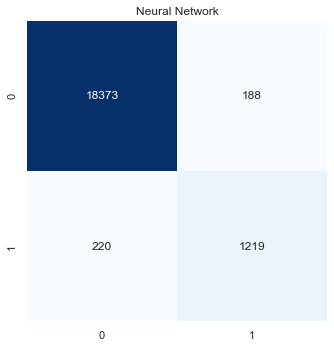

In [ ]:
# create subplot and iterate over the classifiers and axes

from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat, square=True, cmap="Blues", annot=True, fmt='d', cbar=False)
ax.title.set_text("Neural Network")
plt.tight_layout()  
plt.show()

In [ ]:
# accuracy metrics

y_test = y_test.astype(int)
y_pred = y_pred.astype(int)


f1 = round(f1_score(y_test,y_pred),3)
recall = round(recall_score(y_test,y_pred),3)
precision = round(precision_score(y_test,y_pred),3)
accuracy = round(accuracy_score(y_test,y_pred),3)
rocauc = round(roc_auc_score(y_test,y_pred),3)
logloss = 0.0718
Correct_Predictions = int(accuracy * len(y_test))
Incorrect_Predictions = int(len(y_test) - (accuracy * len(y_test)))

results_df_norm['NeuralNetwork'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions,Incorrect_Predictions])

results_df_norm.head(8)


,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_norm,0.793,0.853,0.901,0.902,0.891,0.907,0.8570
Recall_norm,0.767,0.862,0.841,0.836,0.846,0.850,0.8470
Precision_norm,0.820,0.844,0.970,0.980,0.941,0.971,0.8660
Accuracy Score_norm,0.971,0.979,0.987,0.987,0.985,0.987,0.9800
ROC AUC_norm,0.877,0.925,0.919,0.917,0.921,0.924,0.9180
LogLoss_norm,0.069,0.741,0.154,0.054,0.589,0.042,0.0718
Correct_Predictions_norm,19420.000,19580.000,19740.000,19740.000,19700.000,19740.000,19600.0000
Incorrect_Predictions_norm,580.000,420.000,260.000,260.000,300.000,260.000,400.0000


# Model training with feature engineering (including oversampling)

Now let's try to improve the models further by using the SMOTE oversampling technique. As mentioned previously, the dataset we're working with is quite imbalanced because positives instances of credit card fraud are just 7% of all the samples. By using SMOTE oversampling we can increase the number of positives instances of fraud by creating artificial samples that have similar characteristics to the existing positive samples. The idea behind oversampling is to help the algorithms learn better the characteristics of positive and negative instances and improve the ability to distinguish between the 2 classes.

In [ ]:
# use SMOTE to perform oversampling of the minority class (fraud)

X_train_smote, y_train_smote = SMOTE(random_state=50).fit_resample(X_train_norm, y_train)
smote_value_counts = y_train_smote.value_counts()
print("Fraudulent transactions are %.2f%% of the train set." % (smote_value_counts[0] * 100 / len(y_train_smote)))

Fraudulent transactions are 50.00% of the train set.


Once again let's instantiate the classifiers in a dictionary and fit them to the oversample training data.

In [ ]:
# create a "classifiers" dictionary and loop through it to train each of the classifiers within

classifiers = {"Logistic Regression":LogisticRegression(max_iter = 1000), 
               "Decision Tree": DecisionTreeClassifier(), 
               "Bagging Classifier" : BaggingClassifier(),
               "Random Forest": RandomForestClassifier(), 
               "Ada Boost Classifier": AdaBoostClassifier(),
               "XGBoost Classifier": xgb.XGBClassifier()}

for key, classifier in classifiers.items():
    classifier.fit(X_train_smote, y_train_smote)

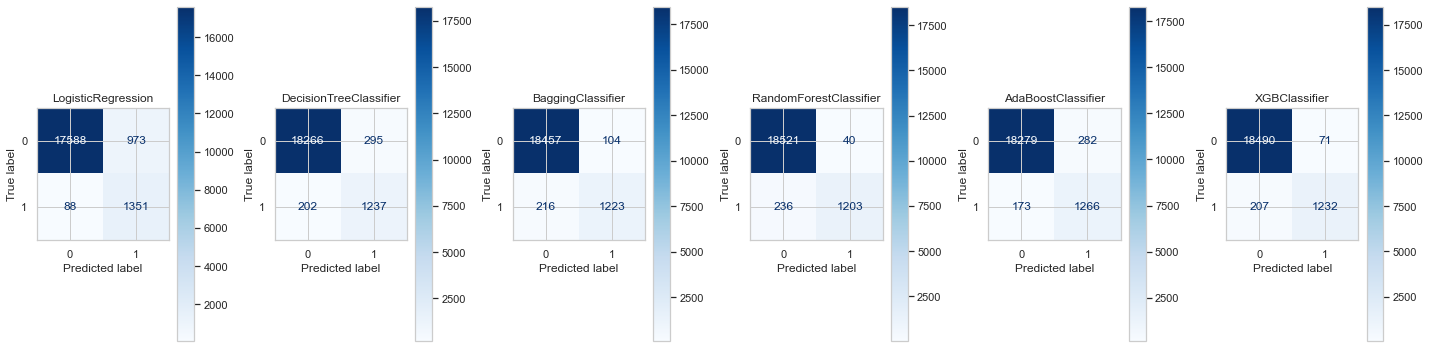

In [ ]:
# create subplot and iterate over the classifiers and axes

from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(nrows=1, ncols=len(classifiers.keys()), figsize=(20,5))

for classifier, ax in zip(classifiers.values(), axes.flatten()):
    ConfusionMatrixDisplay.from_estimator(classifier, 
                                          X_test_norm, 
                                          y_test, 
                                          ax=ax, 
                                          cmap='Blues')
    ax.title.set_text(type(classifier).__name__)
plt.tight_layout()  
plt.show()

In [ ]:
#create df for results

results_df_smote = pd.DataFrame(index=['F1_smote', 'Recall_smote', 'Precision_smote', 'Accuracy Score_smote', 'ROC AUC_smote','LogLoss_smote','Correct_Predictions_smote','Incorrect_Predictions_smote'], 
                         columns = ['Logistic Regression', 'Decision Tree', 'Bagging Classifier',
                                   'Random Forest','Ada Boost Classifier','XGBoost Classifier','NeuralNetwork'])

results_df_smote.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_smote,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recall_smote,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precision_smote,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy Score_smote,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC AUC_smote,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogLoss_smote,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#calculate predictions and probabilities and store results in a df

for classifier, key in zip(classifiers.values(),classifiers.keys()):
    y_pred = classifier.predict(X_test_norm)
    y_prob = classifier.predict_proba(X_test_norm)
    f1_smote = round(f1_score(y_test,y_pred),3)
    recall_smote = round(recall_score(y_test,y_pred),3)
    precision_smote = round(precision_score(y_test,y_pred),3)
    accuracy_smote = round(accuracy_score(y_test,y_pred),3)
    rocauc_smote = round(roc_auc_score(y_test,y_pred),3)
    logloss_smote = round(log_loss(y_test, y_prob),3)
    Correct_Predictions_smote = int(accuracy_smote * len(y_test))
    Incorrect_Predictions_smote = int(len(y_test) - (accuracy_smote * len(y_test)))
    results_df_smote[key] = ([f1_smote, recall_smote, precision_smote, accuracy_smote, rocauc_smote, logloss_smote,Correct_Predictions_smote,Incorrect_Predictions_smote])

results_df_smote.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_smote,0.718,0.833,0.884,0.897,0.848,0.899,NaN
Recall_smote,0.939,0.860,0.850,0.836,0.880,0.856,NaN
Precision_smote,0.581,0.807,0.922,0.968,0.818,0.946,NaN
Accuracy Score_smote,0.947,0.975,0.984,0.986,0.977,0.986,NaN
ROC AUC_smote,0.943,0.922,0.922,0.917,0.932,0.926,NaN
LogLoss_smote,0.120,0.858,0.178,0.055,0.590,0.043,NaN
Correct_Predictions_smote,18940.000,19500.000,19680.000,19720.000,19540.000,19720.000,NaN
Incorrect_Predictions_smote,1060.000,500.000,320.000,280.000,460.000,280.000,NaN


Logistic regression, Ada Boost and XGBoost see the biggest improvements in ROC_AUC and recall scores. The other tree-based models don't register any gains in ROC AUC and in some cases there's very minor decreases in ROC AUC score and recall.

Given that some models see improvements and some others remain practically flat in terms of performance, we'll keep using oversampling when fine tunning hyperparameters in the next stage.

Before that let's train the Neural Network using the oversample dataset

In [ ]:
# Model Hyperparameters

neurons = 16
epochs = 100

#instantiate the model

model_nn = tf.keras.Sequential([
                             tf.keras.layers.Dense(neurons, activation='relu', input_shape=(X_train_smote.shape[-1],)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

model_nn.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives',
                       'FalsePositives', 'FalseNegatives'])

In [ ]:
r = model_nn.fit(X_train_smote, y_train_smote, epochs=epochs, verbose=2, 
                 validation_data=(X_test_norm, y_test), shuffle=True)


Epoch 1/100
4641/4641 - 6s - loss: 0.4207 - accuracy: 0.9089 - auc: 0.9580 - precision: 0.8931 - recall: 0.9290 - true_negatives: 65988.0000 - true_positives: 68971.0000 - false_positives: 8256.0000 - false_negatives: 5273.0000 - val_loss: 0.1231 - val_accuracy: 0.9441 - val_auc: 0.9885 - val_precision: 0.5678 - val_recall: 0.9368 - val_true_negatives: 17535.0000 - val_true_positives: 1348.0000 - val_false_positives: 1026.0000 - val_false_negatives: 91.0000 - 6s/epoch - 1ms/step
Epoch 2/100
4641/4641 - 4s - loss: 0.1153 - accuracy: 0.9553 - auc: 0.9903 - precision: 0.9393 - recall: 0.9736 - true_negatives: 69576.0000 - true_positives: 72282.0000 - false_positives: 4668.0000 - false_negatives: 1962.0000 - val_loss: 0.1351 - val_accuracy: 0.9461 - val_auc: 0.9865 - val_precision: 0.5783 - val_recall: 0.9263 - val_true_negatives: 17589.0000 - val_true_positives: 1333.0000 - val_false_positives: 972.0000 - val_false_negatives: 106.0000 - 4s/epoch - 884us/step
Epoch 3/100
4641/4641 - 4s - l

Epoch 18/100
4641/4641 - 4s - loss: 0.1114 - accuracy: 0.9601 - auc: 0.9906 - precision: 0.9472 - recall: 0.9746 - true_negatives: 70209.0000 - true_positives: 72360.0000 - false_positives: 4035.0000 - false_negatives: 1884.0000 - val_loss: 0.1211 - val_accuracy: 0.9513 - val_auc: 0.9864 - val_precision: 0.6056 - val_recall: 0.9243 - val_true_negatives: 17695.0000 - val_true_positives: 1330.0000 - val_false_positives: 866.0000 - val_false_negatives: 109.0000 - 4s/epoch - 861us/step
Epoch 19/100
4641/4641 - 4s - loss: 0.1104 - accuracy: 0.9599 - auc: 0.9909 - precision: 0.9469 - recall: 0.9746 - true_negatives: 70183.0000 - true_positives: 72355.0000 - false_positives: 4061.0000 - false_negatives: 1889.0000 - val_loss: 0.1370 - val_accuracy: 0.9445 - val_auc: 0.9865 - val_precision: 0.5687 - val_recall: 0.9437 - val_true_negatives: 17531.0000 - val_true_positives: 1358.0000 - val_false_positives: 1030.0000 - val_false_negatives: 81.0000 - 4s/epoch - 867us/step
Epoch 20/100
4641/4641 - 4

Epoch 35/100
4641/4641 - 4s - loss: 0.1096 - accuracy: 0.9607 - auc: 0.9910 - precision: 0.9472 - recall: 0.9757 - true_negatives: 70203.0000 - true_positives: 72443.0000 - false_positives: 4041.0000 - false_negatives: 1801.0000 - val_loss: 0.1230 - val_accuracy: 0.9499 - val_auc: 0.9864 - val_precision: 0.5976 - val_recall: 0.9319 - val_true_negatives: 17658.0000 - val_true_positives: 1341.0000 - val_false_positives: 903.0000 - val_false_negatives: 98.0000 - 4s/epoch - 863us/step
Epoch 36/100
4641/4641 - 4s - loss: 0.1101 - accuracy: 0.9606 - auc: 0.9908 - precision: 0.9478 - recall: 0.9748 - true_negatives: 70259.0000 - true_positives: 72374.0000 - false_positives: 3985.0000 - false_negatives: 1870.0000 - val_loss: 0.1309 - val_accuracy: 0.9473 - val_auc: 0.9864 - val_precision: 0.5830 - val_recall: 0.9395 - val_true_negatives: 17594.0000 - val_true_positives: 1352.0000 - val_false_positives: 967.0000 - val_false_negatives: 87.0000 - 4s/epoch - 878us/step
Epoch 37/100
4641/4641 - 4s 

Epoch 52/100
4641/4641 - 4s - loss: 0.1092 - accuracy: 0.9608 - auc: 0.9910 - precision: 0.9473 - recall: 0.9758 - true_negatives: 70213.0000 - true_positives: 72447.0000 - false_positives: 4031.0000 - false_negatives: 1797.0000 - val_loss: 0.1308 - val_accuracy: 0.9446 - val_auc: 0.9858 - val_precision: 0.5695 - val_recall: 0.9458 - val_true_negatives: 17532.0000 - val_true_positives: 1361.0000 - val_false_positives: 1029.0000 - val_false_negatives: 78.0000 - 4s/epoch - 899us/step
Epoch 53/100
4641/4641 - 4s - loss: 0.1099 - accuracy: 0.9605 - auc: 0.9911 - precision: 0.9473 - recall: 0.9754 - true_negatives: 70212.0000 - true_positives: 72417.0000 - false_positives: 4032.0000 - false_negatives: 1827.0000 - val_loss: 0.1322 - val_accuracy: 0.9473 - val_auc: 0.9863 - val_precision: 0.5828 - val_recall: 0.9388 - val_true_negatives: 17594.0000 - val_true_positives: 1351.0000 - val_false_positives: 967.0000 - val_false_negatives: 88.0000 - 4s/epoch - 906us/step
Epoch 54/100
4641/4641 - 4s

Epoch 69/100
4641/4641 - 4s - loss: 0.1085 - accuracy: 0.9615 - auc: 0.9912 - precision: 0.9492 - recall: 0.9751 - true_negatives: 70371.0000 - true_positives: 72399.0000 - false_positives: 3873.0000 - false_negatives: 1845.0000 - val_loss: 0.1319 - val_accuracy: 0.9455 - val_auc: 0.9862 - val_precision: 0.5738 - val_recall: 0.9402 - val_true_negatives: 17556.0000 - val_true_positives: 1353.0000 - val_false_positives: 1005.0000 - val_false_negatives: 86.0000 - 4s/epoch - 894us/step
Epoch 70/100
4641/4641 - 4s - loss: 0.1099 - accuracy: 0.9613 - auc: 0.9910 - precision: 0.9488 - recall: 0.9753 - true_negatives: 70336.0000 - true_positives: 72412.0000 - false_positives: 3908.0000 - false_negatives: 1832.0000 - val_loss: 0.1281 - val_accuracy: 0.9487 - val_auc: 0.9854 - val_precision: 0.5905 - val_recall: 0.9340 - val_true_negatives: 17629.0000 - val_true_positives: 1344.0000 - val_false_positives: 932.0000 - val_false_negatives: 95.0000 - 4s/epoch - 870us/step
Epoch 71/100
4641/4641 - 4s

Epoch 86/100
4641/4641 - 4s - loss: 0.1086 - accuracy: 0.9614 - auc: 0.9910 - precision: 0.9489 - recall: 0.9752 - true_negatives: 70347.0000 - true_positives: 72402.0000 - false_positives: 3897.0000 - false_negatives: 1842.0000 - val_loss: 0.1265 - val_accuracy: 0.9489 - val_auc: 0.9862 - val_precision: 0.5914 - val_recall: 0.9375 - val_true_negatives: 17629.0000 - val_true_positives: 1349.0000 - val_false_positives: 932.0000 - val_false_negatives: 90.0000 - 4s/epoch - 867us/step
Epoch 87/100
4641/4641 - 4s - loss: 0.1091 - accuracy: 0.9611 - auc: 0.9910 - precision: 0.9486 - recall: 0.9751 - true_negatives: 70322.0000 - true_positives: 72397.0000 - false_positives: 3922.0000 - false_negatives: 1847.0000 - val_loss: 0.1217 - val_accuracy: 0.9490 - val_auc: 0.9856 - val_precision: 0.5927 - val_recall: 0.9312 - val_true_negatives: 17640.0000 - val_true_positives: 1340.0000 - val_false_positives: 921.0000 - val_false_negatives: 99.0000 - 4s/epoch - 882us/step
Epoch 88/100
4641/4641 - 4s 

In [ ]:
# Convert all the outputs to booleans (just makes it easier to see)
threshold = 0.5

y_pred = model_nn.predict(X_test_norm)
y_pred = y_pred > threshold
y_test = y_test > threshold

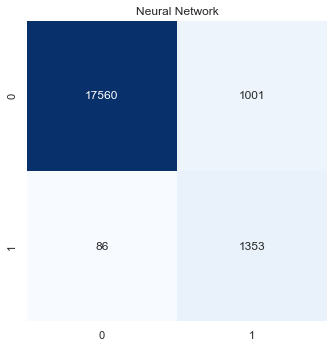

In [ ]:
# create subplot and iterate over the classifiers and axes

from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat, square=True, cmap="Blues", annot=True, fmt='d', cbar=False)
ax.title.set_text("Neural Network")
plt.tight_layout()  
plt.show()

In [ ]:
# accuracy metrics

y_test = y_test.astype(int)
y_pred = y_pred.astype(int)


f1 = round(f1_score(y_test,y_pred),3)
recall = round(recall_score(y_test,y_pred),3)
precision = round(precision_score(y_test,y_pred),3)
accuracy = round(accuracy_score(y_test,y_pred),3)
rocauc = round(roc_auc_score(y_test,y_pred),3)
logloss = 0.1093
Correct_Predictions = int(accuracy * len(y_test))
Incorrect_Predictions = int(len(y_test) - (accuracy * len(y_test)))

results_df_smote['NeuralNetwork'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions,Incorrect_Predictions])

results_df_smote.head(8)


,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_smote,0.718,0.833,0.884,0.897,0.848,0.899,0.7130
Recall_smote,0.939,0.860,0.850,0.836,0.880,0.856,0.9400
Precision_smote,0.581,0.807,0.922,0.968,0.818,0.946,0.5750
Accuracy Score_smote,0.947,0.975,0.984,0.986,0.977,0.986,0.9460
ROC AUC_smote,0.943,0.922,0.922,0.917,0.932,0.926,0.9430
LogLoss_smote,0.120,0.858,0.178,0.055,0.590,0.043,0.1093
Correct_Predictions_smote,18940.000,19500.000,19680.000,19720.000,19540.000,19720.000,18920.0000
Incorrect_Predictions_smote,1060.000,500.000,320.000,280.000,460.000,280.000,1080.0000


In [ ]:
results_df_norm.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_norm,0.793,0.853,0.901,0.902,0.891,0.907,0.8570
Recall_norm,0.767,0.862,0.841,0.836,0.846,0.850,0.8470
Precision_norm,0.820,0.844,0.970,0.980,0.941,0.971,0.8660
Accuracy Score_norm,0.971,0.979,0.987,0.987,0.985,0.987,0.9800
ROC AUC_norm,0.877,0.925,0.919,0.917,0.921,0.924,0.9180
LogLoss_norm,0.069,0.741,0.154,0.054,0.589,0.042,0.0718
Correct_Predictions_norm,19420.000,19580.000,19740.000,19740.000,19700.000,19740.000,19600.0000
Incorrect_Predictions_norm,580.000,420.000,260.000,260.000,300.000,260.000,400.0000


# Model Hyperparameter tunning (XGBoost)

With the objective of improving each individual model further, let's try to find if changing the default values of their hyperparameters can have a positive impact. In order to find out the optimal hyperparameter values for each classifier we're going to use a 5 fold cross validation to set a baseline score which we'll use as a benchmark to compare the performance of the same model with different hyperparameter values.

In [ ]:
#initialize base model

model_xg = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', eval_metric="auc")

Define the cross-validation object using a 5-fold cross-validation

In [ ]:
# to make sure we're splitting data consistently when doing cross-validation we're going to use StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Score and print Recall, F1 and ROC AUC for the base model on the training data.

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_xg, X_train_smote, y_train_smote, cv=kfold, scoring='recall')
f1 = cross_val_score(model_xg, X_train_smote, y_train_smote, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_xg, X_train_smote, y_train_smote, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.989 0.987 0.989 0.989 0.987]
F1: [0.993 0.992 0.993 0.993 0.992]
ROC AUC: [1.    0.999 1.    1.    1.   ]
Recall mean: 0.98835
F1 mean: 0.99268
ROC AUC mean: 0.99953


Next we'll define a function that we're going to use to find the optimal hyperparameters for each model. In the function we'll instantiate the classifier and the cross-validator object. We'll then perform a grid search to find which parameters produce the best ROC AUC score in the cross-validation. The parameters are going to be passed as a dictionary when running the function.

In [ ]:
#combining GridSearchCV and RandomizedSearchCV to fine tune
#defining a grid_search function with the params dictionary as input, along with random=False

def grid_search_xg(X_train, y_train, params, random=False):
    
    model_xg = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', eval_metric="auc")
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        #grid = RandomizedSearchCV(model_xg, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        #uncomment to perform randomizedsearch as opposed to gridsearch
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_xg, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))


Now let's define the parameters and perform the grid search to find the optimal parameters for XGBoost classifier. We'll perform the grid search over 1000 rows only to run it faster. For XGBoost we'll split this process into two steps to improve the processing times.

In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 1000)

grid_search_xg(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,], 
                    
                    params={
                    'learning_rate':[0.1, 0.2, 0.3],

                    'max_depth':[2, 3, 4, 5, 6],

                    'n_estimators':[5, 25, 100, 500]},

                    random=True)

Best params: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}
Best score: 0.99872


Let's run grid search again with the results above to find the next set of optimal parameters.

In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 1000)

grid_search_xg(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,], 
                    
                    params={

                    'learning_rate':[0.2],

                    'max_depth':[2],

                    'n_estimators':[100],
                   
                    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    
                    'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    
                    'colsample_bynode':[0.5, 0.6, 0.7, 0.8, 0.9, 1]},

                    random=True)

Best params: {'colsample_bylevel': 0.7, 'colsample_bynode': 0.5, 'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 100}
Best score: 0.99872


There's a modest improvent in the ROC AUC score so let's instantiate the model adding the hyperparameter values we found during grid search. 

In [ ]:
# fit XGBoost model with tuned parameters 

model_xg = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', eval_metric='auc', 
                           n_estimators = 100, max_depth = 2, learning_rate = 0.2, 
                           colsample_bytree = 0.7, colsample_bynode= 0.5, colsample_bylevel= 0.7)

Now fit the model

In [ ]:
#fit the new model

model_xg.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.7, colsample_bynode=0.5, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
results_df_tunned = pd.DataFrame(index=['F1_tunned', 'Recall_tunned', 'Precision_tunned', 'Accuracy Score_tunned', 'ROC AUC_tunned','LogLoss_tunned','Correct_Predictions_tunned','Incorrect_Predictions_tunned'], 
                         columns = ['Logistic Regression', 'Decision Tree', 'Bagging Classifier',
                                   'Random Forest','Ada Boost Classifier','XGBoost Classifier','NeuralNetwork'])

results_df_tunned.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recall_tunned,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precision_tunned,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy Score_tunned,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC AUC_tunned,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogLoss_tunned,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And store the results in a new table

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_xg.predict(X_test_norm)
probability = model_xg.predict_proba(X_test_norm)

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned = int(accuracy * len(y_test))
Incorrect_Predictions_tunned = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned['XGBoost Classifier'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned,Incorrect_Predictions_tunned])

results_df_tunned.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned,NaN,NaN,NaN,NaN,NaN,0.860,NaN
Recall_tunned,NaN,NaN,NaN,NaN,NaN,0.870,NaN
Precision_tunned,NaN,NaN,NaN,NaN,NaN,0.849,NaN
Accuracy Score_tunned,NaN,NaN,NaN,NaN,NaN,0.980,NaN
ROC AUC_tunned,NaN,NaN,NaN,NaN,NaN,0.929,NaN
LogLoss_tunned,NaN,NaN,NaN,NaN,NaN,0.050,NaN
Correct_Predictions_tunned,NaN,NaN,NaN,NaN,NaN,19600.000,NaN
Incorrect_Predictions_tunned,NaN,NaN,NaN,NaN,NaN,400.000,NaN


# Model Hyperparameter tunning (Logistic Regression)

Now let's repeat the same process for the logistic regression classifier.

In [ ]:
# logistic regression

#initialize base model

model_lr = LogisticRegression(max_iter=1000)

In [ ]:
# to make sure we're splitting data consistently we're going to use StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In this particular case we're also going to scale the numerical variables using MinMaxScaler to help the logistic regression algorithm converge faster. 

In [ ]:
#run scaler for the logistic regression model

columns_scale = ['Time','Amount','Age']

#run scaler across these columns

X_train_scale = X_train.copy()

X_test_scale = X_test.copy()

# initialize scaler

scaler = MinMaxScaler()

scaler.fit(X_train_smote[columns_scale])

# scale

X_train_scale[['Time','Amount','Age']] = scaler.transform(X_train[columns_scale])

X_test_scale[['Time','Amount','Age']] = scaler.transform(X_test[columns_scale])

Because we scaled the original training and test datasets we need to perform Smote oversampling again on the scaled dataset.

In [ ]:
# use SMOTE to perform oversampling of the minority class (fraud)

X_train_scale_smote, y_train_smote = SMOTE(random_state=50).fit_resample(X_train_scale, y_train)
smote_value_counts = y_train_smote.value_counts()
print("Fraudulent transactions are %.2f%% of the train set." % (smote_value_counts[0] * 100 / len(y_train_smote)))

Fraudulent transactions are 50.00% of the train set.


Now let's run cross validation to set a baseline score for the tunned logistic regression algorithm.

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_lr, X_train_scale_smote, y_train_smote, cv=kfold, scoring='recall')
f1 = cross_val_score(model_lr, X_train_scale_smote, y_train_smote, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_lr, X_train_scale_smote, y_train_smote, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.97  0.971 0.97  0.973 0.971]
F1: [0.955 0.954 0.954 0.957 0.956]
ROC AUC: [0.991 0.99  0.991 0.992 0.991]
Recall mean: 0.97110
F1 mean: 0.95509
ROC AUC mean: 0.99121


Define the grid search function.

In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_lr(X_train, y_train, params, random=False):
    
    model_lr = LogisticRegression(max_iter=1000)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        #grid = RandomizedSearchCV(model_lr, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_lr, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))


Perform the grid search.

In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train_scale_smote.index)).tolist(), 1000)

grid_search_lr(X_train_scale_smote.iloc[rows,], y_train_smote.iloc[rows,], 
                    
                    params={'solver':['newton-cg', 'lbfgs','liblinear'],
                            'penalty':['none', 'l1','l2','elasticnet'],
                            'C':[100, 10, 1.0, 0.1, 0.01]},
                    random=True)



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting

Best params: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.98858


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


The best ROC AUC score in the grid search is lower than the ROC AUC we obtained in the baseline so we'll run the model without hyperparameter tunning and use the default values instead.

In [ ]:
# fit Logistic Regression model with tuned parameters 

model_lr = LogisticRegression(max_iter=1000)

In [ ]:
#fit the new model

model_lr.fit(X_train_scale_smote, y_train_smote)



LogisticRegression(max_iter=1000)

Let's store the results in the same table.

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_lr.predict(X_test_scale)
probability = model_lr.predict_proba(X_test_scale)

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability))
Correct_Predictions_tunned = int(accuracy * len(y_test))
Incorrect_Predictions_tunned = int(len(y_test) - (accuracy * len(y_test)))
results_df_tunned['Logistic Regression'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned,Incorrect_Predictions_tunned])

results_df_tunned.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned,0.686,NaN,NaN,NaN,NaN,0.860,NaN
Recall_tunned,0.947,NaN,NaN,NaN,NaN,0.870,NaN
Precision_tunned,0.537,NaN,NaN,NaN,NaN,0.849,NaN
Accuracy Score_tunned,0.938,NaN,NaN,NaN,NaN,0.980,NaN
ROC AUC_tunned,0.942,NaN,NaN,NaN,NaN,0.929,NaN
LogLoss_tunned,0.000,NaN,NaN,NaN,NaN,0.050,NaN
Correct_Predictions_tunned,18760.000,NaN,NaN,NaN,NaN,19600.000,NaN
Incorrect_Predictions_tunned,1240.000,NaN,NaN,NaN,NaN,400.000,NaN


# Model Hyperparameter tunning (Decision Tree)

Repeat the same process for the Decision tree classifier

In [ ]:
# decision tree regression

#initialize base model

model_dt = DecisionTreeClassifier()

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_dt, X_train_smote, y_train_smote, cv=kfold, scoring='recall')
f1 = cross_val_score(model_dt, X_train_smote, y_train_smote, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_dt, X_train_smote, y_train_smote, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.989 0.988 0.99  0.989 0.988]
F1: [0.988 0.987 0.988 0.988 0.987]
ROC AUC: [0.988 0.987 0.988 0.988 0.987]
Recall mean: 0.98874
F1 mean: 0.98778
ROC AUC mean: 0.98785


In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_dt(X_train, y_train, params, random=False):
    
    model_dt = DecisionTreeClassifier()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        #grid = RandomizedSearchCV(model_dt, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_dt, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 1000)

grid_search_dt(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,], 
                    
                    params={'max_depth':[1, 2 , 3, 10, 20],

                    'min_samples_split':[0.1, 0.2,0.5,1],
               
                    'min_samples_leaf': [0.02,0.04, 0.06, 0.08]},
               
                    random=True)

Best params: {'max_depth': 10, 'min_samples_leaf': 0.02, 'min_samples_split': 0.1}
Best score: 0.98972


Hyperparameter tunning didn't improve the score from the cross-validation so we're going to instantiate the model with the default parameters

In [ ]:
# fit Decisiontree model with tuned parameters 

model_dt = DecisionTreeClassifier()

In [ ]:
#fit the new model

model_dt.fit(X_train_smote, y_train_smote)

DecisionTreeClassifier()

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_dt.predict(X_test_norm)
probability = model_dt.predict_proba(X_test_norm) 

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned = int(accuracy * len(y_test))
Incorrect_Predictions_tunned = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned['Decision Tree'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned,Incorrect_Predictions_tunned])

results_df_tunned.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned,0.686,0.834,NaN,NaN,NaN,0.860,NaN
Recall_tunned,0.947,0.864,NaN,NaN,NaN,0.870,NaN
Precision_tunned,0.537,0.805,NaN,NaN,NaN,0.849,NaN
Accuracy Score_tunned,0.938,0.975,NaN,NaN,NaN,0.980,NaN
ROC AUC_tunned,0.942,0.924,NaN,NaN,NaN,0.929,NaN
LogLoss_tunned,0.000,0.857,NaN,NaN,NaN,0.050,NaN
Correct_Predictions_tunned,18760.000,19500.000,NaN,NaN,NaN,19600.000,NaN
Incorrect_Predictions_tunned,1240.000,500.000,NaN,NaN,NaN,400.000,NaN


# Model Hyperparameter tunning (Bagging Classifier)

Repeat the same process for the bagging classifier

In [ ]:
# bagging classifier

#initialize base model

model_bc = BaggingClassifier()

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_bc, X_train_smote, y_train_smote, cv=kfold, scoring='recall')
f1 = cross_val_score(model_bc, X_train_smote, y_train_smote, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_bc, X_train_smote, y_train_smote, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.989 0.986 0.988 0.988 0.987]
F1: [0.993 0.992 0.992 0.992 0.991]
ROC AUC: [0.998 0.998 0.998 0.998 0.997]
Recall mean: 0.98764
F1 mean: 0.99207
ROC AUC mean: 0.99762


In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_bc(X_train, y_train, params, random=False):
    
    model_bc = BaggingClassifier()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        #grid = RandomizedSearchCV(model_bc, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_bc, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [ ]:
# search optimal values of all parameters at once over 100 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 100)

grid_search_bc(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,], 
                    
                    params={ 'n_estimators':[1, 10, 100, 200],

                    'max_samples':[5, 10, 50, 100]},
               
                    random=True)

Best params: {'max_samples': 5, 'n_estimators': 100}
Best score: 0.99085


There's a modest increase in ROC AUC so let's use those to fit the model again.

In [ ]:
# fit Decisiontree model with tuned parameters 

model_bc = BaggingClassifier(max_samples = 5, n_estimators = 100)

In [ ]:
#fit the new model

model_bc.fit(X_train_smote, y_train_smote)

BaggingClassifier(max_samples=5, n_estimators=100)

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_bc.predict(X_test_norm)
probability = model_bc.predict_proba(X_test_norm) 

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned = int(accuracy * len(y_test))
Incorrect_Predictions_tunned = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned['Bagging Classifier'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned,Incorrect_Predictions_tunned])

results_df_tunned.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned,0.686,0.834,0.681,NaN,NaN,0.860,NaN
Recall_tunned,0.947,0.864,0.853,NaN,NaN,0.870,NaN
Precision_tunned,0.537,0.805,0.567,NaN,NaN,0.849,NaN
Accuracy Score_tunned,0.938,0.975,0.943,NaN,NaN,0.980,NaN
ROC AUC_tunned,0.942,0.924,0.901,NaN,NaN,0.929,NaN
LogLoss_tunned,0.000,0.857,0.350,NaN,NaN,0.050,NaN


# Model Hyperparameter tunning (Random Forest)

Repeat the same process for the Random Forest classifier

In [ ]:
#initialize base model

model_rf = RandomForestClassifier()

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_rf, X_train_smote, y_train_smote, cv=kfold, scoring='recall')
f1 = cross_val_score(model_rf, X_train_smote, y_train_smote, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_rf, X_train_smote, y_train_smote, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.989 0.987 0.988 0.988 0.986]
F1: [0.993 0.992 0.993 0.993 0.992]
ROC AUC: [1.    0.999 0.999 1.    1.   ]
Recall mean: 0.98764
F1 mean: 0.99237
ROC AUC mean: 0.99950


In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_rf(X_train, y_train, params, random=False):
    
    model_rf = RandomForestClassifier()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        #grid = RandomizedSearchCV(model_rf, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_rf, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 1000)

grid_search_rf(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,], 
                    
                    params={ 'n_estimators':[1, 10, 100, 200, 500],

                    'max_depth':[5, 10, 15, 25, 30]},
               
                    random=True)

Best params: {'max_depth': 25, 'n_estimators': 100}
Best score: 0.99855


Hyperparameter tunning didn't improve the score from the cross-validation so we're going to instantiate the model with the default parameters

In [ ]:
# fit RandomForest model with tuned parameters 

model_rf = RandomForestClassifier()

In [ ]:
#fit the new model

model_rf.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_rf.predict(X_test_norm)
probability = model_rf.predict_proba(X_test_norm)

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned = int(accuracy * len(y_test))
Incorrect_Predictions_tunned = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned['Random Forest'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned,Incorrect_Predictions_tunned])

results_df_tunned.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned,0.686,0.834,0.681,0.898,NaN,0.860,NaN
Recall_tunned,0.947,0.864,0.853,0.839,NaN,0.870,NaN
Precision_tunned,0.537,0.805,0.567,0.966,NaN,0.849,NaN
Accuracy Score_tunned,0.938,0.975,0.943,0.986,NaN,0.980,NaN
ROC AUC_tunned,0.942,0.924,0.901,0.918,NaN,0.929,NaN
LogLoss_tunned,0.000,0.857,0.350,0.053,NaN,0.050,NaN
Correct_Predictions_tunned,18760.000,19500.000,18860.000,19720.000,NaN,19600.000,NaN
Incorrect_Predictions_tunned,1240.000,500.000,1140.000,280.000,NaN,400.000,NaN


# Model Hyperparameter tunning ( Ada Boost)

Repeat the same process for the Ada Boost classifier

In [ ]:
#initialize base model

model_ab = AdaBoostClassifier()

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_ab, X_train_smote, y_train_smote, cv=kfold, scoring='recall')
f1 = cross_val_score(model_ab, X_train_smote, y_train_smote, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_ab, X_train_smote, y_train_smote, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.99  0.99  0.989 0.989 0.989]
F1: [0.988 0.987 0.988 0.988 0.989]
ROC AUC: [0.999 0.999 0.999 1.    0.999]
Recall mean: 0.98959
F1 mean: 0.98793
ROC AUC mean: 0.99946


In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_ab(X_train, y_train, params, random=False):
    
    model_ab = AdaBoostClassifier()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        #grid = RandomizedSearchCV(model_ab, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_ab, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [ ]:
# search optimal values of all parameters at once over 100 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train_smote.index)).tolist(), 100)

grid_search_ab(X_train_smote.iloc[rows,], y_train_smote.iloc[rows,], 
                    
                    params={ 'n_estimators':[50, 100, 500],

                    'learning_rate':[0.1, 1, 2]},
               
                    random=True)

Best params: {'learning_rate': 0.1, 'n_estimators': 100}
Best score: 0.99798


Hyperparameter tunning didn't improve the score from the cross-validation so we're going to instantiate the model with the default parameters

In [ ]:
# fit AdaBoost model with tuned parameters 

model_ab = AdaBoostClassifier()

In [ ]:
#fit the new model

model_ab.fit(X_train_smote, y_train_smote)

AdaBoostClassifier()

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_ab.predict(X_test_norm)
probability = model_ab.predict_proba(X_test_norm) #model.predict_proba(X_test)[:,1]

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned = int(accuracy * len(y_test))
Incorrect_Predictions_tunned = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned['Ada Boost Classifier'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned,Incorrect_Predictions_tunned])

results_df_tunned.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned,0.686,0.834,0.681,0.898,0.848,0.860,NaN
Recall_tunned,0.947,0.864,0.853,0.839,0.880,0.870,NaN
Precision_tunned,0.537,0.805,0.567,0.966,0.818,0.849,NaN
Accuracy Score_tunned,0.938,0.975,0.943,0.986,0.977,0.980,NaN
ROC AUC_tunned,0.942,0.924,0.901,0.918,0.932,0.929,NaN
LogLoss_tunned,0.000,0.857,0.350,0.053,0.590,0.050,NaN
Correct_Predictions_tunned,18760.000,19500.000,18860.000,19720.000,19540.000,19600.000,NaN
Incorrect_Predictions_tunned,1240.000,500.000,1140.000,280.000,460.000,400.000,NaN


In [ ]:
results_df_smote.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_smote,0.718,0.833,0.884,0.897,0.848,0.899,0.7130
Recall_smote,0.939,0.860,0.850,0.836,0.880,0.856,0.9400
Precision_smote,0.581,0.807,0.922,0.968,0.818,0.946,0.5750
Accuracy Score_smote,0.947,0.975,0.984,0.986,0.977,0.986,0.9460
ROC AUC_smote,0.943,0.922,0.922,0.917,0.932,0.926,0.9430
LogLoss_smote,0.120,0.858,0.178,0.055,0.590,0.043,0.1093
Correct_Predictions_smote,18940.000,19500.000,19680.000,19720.000,19540.000,19720.000,18920.0000
Incorrect_Predictions_smote,1060.000,500.000,320.000,280.000,460.000,280.000,1080.0000


Given that some of this classifiers have hyperparameters that can be tweaked to account for imbalance in the training data set, let's explore the results we could get fine tunning this parameters instead of using an oversampled training dataset.

# Model Hyperparameter tunning (XGBoost) - No oversampling or normalisation

XGBoost has a "scale_pos_weight" hyperparameter which can be changed to reflect the imbalance in the classes dataset. According to the XGBoost documentation "scale_pos_weight" should be set at the ratio of "negative class / positive class". Let's calculate that ratio first for this data set.

In [ ]:
counter = Counter(df['Fraud'])

# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 12.902


In [ ]:
minority_class = df['fraudulent'].sum()

majority_class = df['legit'].sum()

scale_weight = majority_class/minority_class

print('Estimate: %.3f' % scale_weight)

Estimate: 12.902


Now let's instantiate the model using the new "scale_pos_weight" value

In [ ]:
#initialize base model

model_xg = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', eval_metric="auc", scale_pos_weight=13)

And repeat the grid search for the other hyperparameters

In [ ]:
# to make sure we're splitting data consistently when doing cross-validation we're going to use StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_xg, X_train, y_train, cv=kfold, scoring='recall')
f1 = cross_val_score(model_xg, X_train, y_train, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_xg, X_train, y_train, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.906 0.886 0.884 0.892 0.904]
F1: [0.828 0.813 0.808 0.822 0.815]
ROC AUC: [0.993 0.992 0.993 0.994 0.993]
Recall mean: 0.89468
F1 mean: 0.81716
ROC AUC mean: 0.99301


In [ ]:
#combining GridSearchCV and RandomizedSearchCV to fine tune
#defining a grid_search function with the params dictionary as input, along with random=False

def grid_search_xg(X_train, y_train, params, random=False):
    
    model_xg = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', eval_metric="auc", scale_pos_weight=13)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        #grid = RandomizedSearchCV(model_xg, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_xg, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))


In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 1000)

grid_search_xg(X_train.iloc[rows,], y_train.iloc[rows,], 
                    
                    params={
                    'learning_rate':[0.1, 0.2, 0.3],

                    'max_depth':[1, 2, 3, 4, 5, 6, 7, 8],

                    'n_estimators':[5, 10, 25, 40, 100, 500]},

                    random=True)

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best score: 0.99115


In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 1000)

grid_search_xg(X_train.iloc[rows,], y_train.iloc[rows,], 
                    
                    params={

                    'learning_rate':[0.3],

                    'max_depth':[7],

                    'n_estimators':[500],
                   
                    'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    
                    'colsample_bylevel':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    
                    'colsample_bynode':[0.5, 0.6, 0.7, 0.8, 0.9, 1]},

                    random=True)

Best params: {'colsample_bylevel': 0.6, 'colsample_bynode': 0.7, 'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 500}
Best score: 0.98420


Let's fit the model with the different hyperparameters we got from the grid search and "scale_pos_weight = 13"

In [ ]:
# fit XGBoost model with tuned parameters 

model_xg = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', eval_metric='auc', scale_pos_weight=13,
                           n_estimators = 100, max_depth = 2, learning_rate = 0.2, 
                           colsample_bytree = 0.6, colsample_bynode= 0.5, colsample_bylevel= 0.6)

In [ ]:
#fit the new model

model_xg.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=0.6, colsample_bynode=0.5, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
results_df_tunned_noOS = pd.DataFrame(index=['F1_tunned_noOS', 'Recall_tunned_noOS', 'Precision_tunned_noOS', 'Accuracy Score_tunned_noOS', 'ROC AUC_tunned_noOS','LogLoss_tunned_noOS','Correct_Predictions_tunned_noOS','Incorrect_Predictions_tunned_noOS'], 
                         columns = ['Logistic Regression', 'Decision Tree', 'Bagging Classifier',
                                   'Random Forest','Ada Boost Classifier','XGBoost Classifier','NeuralNetwork'])

results_df_tunned_noOS.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned_noOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recall_tunned_noOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Precision_tunned_noOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Accuracy Score_tunned_noOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ROC AUC_tunned_noOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LogLoss_tunned_noOS,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And store the results in a df

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_xg.predict(X_test)
probability = model_xg.predict_proba(X_test)

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned_noOS = int(accuracy * len(y_test))
Incorrect_Predictions_tunned_noOS = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned_noOS['XGBoost Classifier'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned_noOS,Incorrect_Predictions_tunned_noOS])

results_df_tunned_noOS.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned_noOS,NaN,NaN,NaN,NaN,NaN,0.706,NaN
Recall_tunned_noOS,NaN,NaN,NaN,NaN,NaN,0.964,NaN
Precision_tunned_noOS,NaN,NaN,NaN,NaN,NaN,0.557,NaN
Accuracy Score_tunned_noOS,NaN,NaN,NaN,NaN,NaN,0.942,NaN
ROC AUC_tunned_noOS,NaN,NaN,NaN,NaN,NaN,0.952,NaN
LogLoss_tunned_noOS,NaN,NaN,NaN,NaN,NaN,0.107,NaN


Let's also look at a confusion matrix to appreciate the difference this has made in the recall.

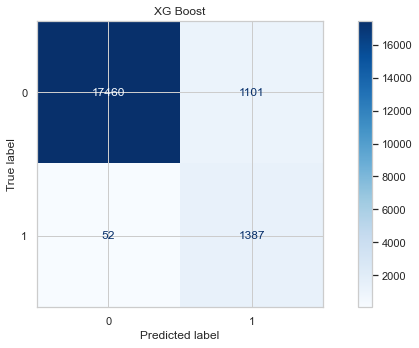

In [ ]:
#create confusion matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ConfusionMatrixDisplay.from_estimator(model_xg, 
                                          X_test, 
                                          y_test, 
                                          ax=ax, 
                                          cmap='Blues')
ax.title.set_text("XG Boost")
plt.tight_layout()  
plt.show()

# Model Hyperparameter tunning (Decision Tree) - No oversampling or normalisation

Let's try to do the same with Decision Tree. In this case the hyperparameter to compensate for the imbalance in the training set is "class_weight". The DecisionTree classifier has the option to automatically set this hyperparameter to "balanced" and automatically calculate the ratio of negative classes over positive classes.

In [ ]:
# decision tree regression

#initialize base model

model_dt = DecisionTreeClassifier(class_weight='balanced')

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_dt, X_train, y_train, cv=kfold, scoring='recall')
f1 = cross_val_score(model_dt, X_train, y_train, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_dt, X_train, y_train, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.864 0.842 0.84  0.835 0.859]
F1: [0.868 0.843 0.85  0.848 0.854]
ROC AUC: [0.926 0.915 0.914 0.915 0.924]
Recall mean: 0.84810
F1 mean: 0.85251
ROC AUC mean: 0.91883


In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_dt(X_train, y_train, params, random=False):
    
    model_dt = DecisionTreeClassifier(class_weight='balanced')
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        #grid = RandomizedSearchCV(model_dt, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_dt, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 1000)

grid_search_dt(X_train.iloc[rows,], y_train.iloc[rows,], 
                    
                    params={'max_depth':[1, 2 , 3, 10, 20],

                    'min_samples_split':[0.1, 0.2,0.5,1],
               
                    'min_samples_leaf': [0.02,0.04, 0.06, 0.08]},
               
                    random=True)

Best params: {'max_depth': 3, 'min_samples_leaf': 0.02, 'min_samples_split': 0.1}
Best score: 0.97741


In [ ]:
# fit Decisiontree model with tuned parameters 

model_dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 0.1, min_samples_leaf = 0.02,
                                  class_weight = 'balanced')



In [ ]:
#fit the new model

model_dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_leaf=0.02, min_samples_split=0.1)

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_dt.predict(X_test)
probability = model_dt.predict_proba(X_test)

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned_noOS = int(accuracy * len(y_test))
Incorrect_Predictions_tunned_noOS = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned_noOS['Decision Tree'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned_noOS,Incorrect_Predictions_tunned_noOS])

results_df_tunned_noOS.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned_noOS,NaN,0.584,NaN,NaN,NaN,0.706,NaN
Recall_tunned_noOS,NaN,0.985,NaN,NaN,NaN,0.964,NaN
Precision_tunned_noOS,NaN,0.415,NaN,NaN,NaN,0.557,NaN
Accuracy Score_tunned_noOS,NaN,0.899,NaN,NaN,NaN,0.942,NaN
ROC AUC_tunned_noOS,NaN,0.939,NaN,NaN,NaN,0.952,NaN
LogLoss_tunned_noOS,NaN,0.200,NaN,NaN,NaN,0.107,NaN
Correct_Predictions_tunned_noOS,NaN,17980.000,NaN,NaN,NaN,18840.000,NaN
Incorrect_Predictions_tunned_noOS,NaN,2020.000,NaN,NaN,NaN,1160.000,NaN


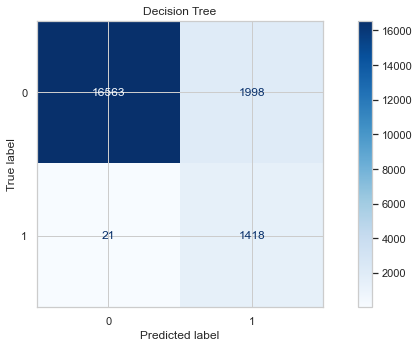

In [ ]:
#create confusion matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

ConfusionMatrixDisplay.from_estimator(model_dt, 
                                          X_test, 
                                          y_test, 
                                          ax=ax, 
                                          cmap='Blues')
ax.title.set_text("Decision Tree")
plt.tight_layout()  
plt.show()

# Model Hyperparameter tunning (Bagging Classifier) - No oversampling or normalisation

In the case of Balance Classifier we'll instantiate a model called "Balanced Bagging Classifier" which includes an additonal step to balance the training data. The default sampler to balance the training data is the "Random Under Sampler"

In [ ]:
# bagging classifier

#initialize base model

model_bbc = BalancedBaggingClassifier()

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_bbc, X_train, y_train, cv=kfold, scoring='recall')
f1 = cross_val_score(model_bbc, X_train, y_train, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_bbc, X_train, y_train, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.941 0.909 0.929 0.923 0.932]
F1: [0.75  0.757 0.76  0.751 0.757]
ROC AUC: [0.991 0.99  0.99  0.992 0.991]
Recall mean: 0.92683
F1 mean: 0.75494
ROC AUC mean: 0.99088


In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_bbc(X_train, y_train, params, random=False):
    
    model_bc = BalancedBaggingClassifier()
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        grid = RandomizedSearchCV(model_bc, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_bc, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 1000)

grid_search_bbc(X_train.iloc[rows,], y_train.iloc[rows,], 
                    
                    params={ 'n_estimators':[1,5, 10, 25, 40, 50, 70, 100, 200,300],

                    'max_samples':[3, 5, 10, 25, 40, 50, 100, 150, 200, 300]},
               
                    random=True)

Best params: {'max_samples': 100, 'n_estimators': 200}
Best score: 0.98532


Hyperparameter tunning doesn't improve ROC, so we can continue with the default values

In [ ]:
# fit Decisiontree model with tuned parameters 

model_bbc = BalancedBaggingClassifier(max_samples = 100, n_estimators = 200)

In [ ]:
#fit the new model

model_bbc.fit(X_train, y_train)

BalancedBaggingClassifier(max_samples=100, n_estimators=200)

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_bbc.predict(X_test)
probability = model_bbc.predict_proba(X_test)

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned_noOS = int(accuracy * len(y_test))
Incorrect_Predictions_tunned_noOS = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned_noOS['Bagging Classifier'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned_noOS,Incorrect_Predictions_tunned_noOS])

results_df_tunned_noOS.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned_noOS,NaN,0.584,0.655,NaN,NaN,0.706,NaN
Recall_tunned_noOS,NaN,0.985,0.953,NaN,NaN,0.964,NaN
Precision_tunned_noOS,NaN,0.415,0.499,NaN,NaN,0.557,NaN
Accuracy Score_tunned_noOS,NaN,0.899,0.928,NaN,NaN,0.942,NaN
ROC AUC_tunned_noOS,NaN,0.939,0.939,NaN,NaN,0.952,NaN
LogLoss_tunned_noOS,NaN,0.200,0.237,NaN,NaN,0.107,NaN


# Model Hyperparameter tunning (Random Forest) - No oversampling or normalisation

With Random Forest we'll use the same hyperparameter we used for the Decision Tree ("class_weight")

In [ ]:
#initialize base model

model_rf = RandomForestClassifier(class_weight='balanced')

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_rf, X_train, y_train, cv=kfold, scoring='recall')
f1 = cross_val_score(model_rf, X_train, y_train, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_rf, X_train, y_train, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.845 0.821 0.833 0.819 0.836]
F1: [0.905 0.889 0.899 0.89  0.901]
ROC AUC: [0.993 0.992 0.992 0.994 0.993]
Recall mean: 0.83090
F1 mean: 0.89668
ROC AUC mean: 0.99281


In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_rf(X_train, y_train, params, random=False):
    
    model_rf = RandomForestClassifier(class_weight='balanced')
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        grid = RandomizedSearchCV(model_rf, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_rf, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train, y_train)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))

In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train.index)).tolist(), 1000)

grid_search_rf(X_train.iloc[rows,], y_train.iloc[rows,], 
                    
                    params={ 'n_estimators':[1, 10, 25, 50, 70, 100, 200, 300, 400, 500],

                    'max_depth':[3, 5, 10, 15, 25, 30, 40, 50],
                    
                    'min_samples_leaf': [1, 2, 4],
                    
                    'min_samples_split': [2, 5, 10]},
               
                    random=True)

Best params: {'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}
Best score: 0.99355


Can't improve the best score without tunning, so we'll go with the default values.

In [ ]:
# fit RandomForest model with tuned parameters 

model_rf = RandomForestClassifier(class_weight='balanced')

In [ ]:
#fit the new model

model_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_rf.predict(X_test)
probability = model_rf.predict_proba(X_test)

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned_noOS = int(accuracy * len(y_test))
Incorrect_Predictions_tunned_noOS = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned_noOS['Random Forest'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned_noOS,Incorrect_Predictions_tunned_noOS])

results_df_tunned_noOS.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned_noOS,NaN,0.584,0.655,0.901,NaN,0.706,NaN
Recall_tunned_noOS,NaN,0.985,0.953,0.835,NaN,0.964,NaN
Precision_tunned_noOS,NaN,0.415,0.499,0.980,NaN,0.557,NaN
Accuracy Score_tunned_noOS,NaN,0.899,0.928,0.987,NaN,0.942,NaN
ROC AUC_tunned_noOS,NaN,0.939,0.939,0.917,NaN,0.952,NaN
LogLoss_tunned_noOS,NaN,0.200,0.237,0.051,NaN,0.107,NaN


# Model Hyperparameter tunning (Logistic Regression) - No oversampling or normalisation

Same case with the Logistic Regression classifier (using class_weight = 'balanced')

In [ ]:
# logistic regression

#initialize base model

model_lr = LogisticRegression(class_weight = 'balanced')

In [ ]:
# to make sure we're splitting data consistently we're going to use StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
#run scaler for the logistic regression model

columns_scale = ['Time','Amount','Age']

#run scaler across these columns

X_train_scale = X_train.copy()

X_test_scale = X_test.copy()

# initialize scaler

scaler = MinMaxScaler()

scaler.fit(X_train[columns_scale])

# scale

X_train_scale[['Time','Amount','Age']] = scaler.transform(X_train[columns_scale])

X_test_scale[['Time','Amount','Age']] = scaler.transform(X_test[columns_scale])

In [ ]:
#score a model with a consistent split to be able to compare results when fine-tuning using kfold

recall = cross_val_score(model_lr, X_train_scale, y_train, cv=kfold, scoring='recall')
f1 = cross_val_score(model_lr, X_train_scale, y_train, cv=kfold, scoring='f1')
roc_auc = cross_val_score(model_lr, X_train_scale, y_train, cv=kfold, scoring='roc_auc')

print('Recall:', np.round(recall, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))

print('Recall mean: %0.5f' % (recall.mean()))
print('F1 mean: %0.5f' % (f1.mean()))
print('ROC AUC mean: %0.5f' % (roc_auc.mean()))

Recall: [0.97  0.967 0.961 0.964 0.975]
F1: [0.674 0.664 0.663 0.674 0.677]
ROC AUC: [0.989 0.988 0.988 0.989 0.99 ]
Recall mean: 0.96733
F1 mean: 0.67039
ROC AUC mean: 0.98875


In [ ]:
# combining GridSearchCV and RandomizedSearchCV to fine tune
#Define a grid_search function with the params dictionary as input, along with random=False

def grid_search_lr(X_train_scale, y_train_scale, params, random=False):
    
    model_lr = LogisticRegression(class_weight = 'balanced')
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        grid = RandomizedSearchCV(model_lr, params, cv=kfold, n_iter=50, n_jobs=-1, random_state=2, scoring='roc_auc')
        
        # Instantiate GridSearchCV as grid_reg
        grid = GridSearchCV(model_lr, params, cv=kfold, n_jobs=-1, scoring='roc_auc') 
        
    # Fit grid_reg on X_train and y_train
    grid.fit(X_train_scale, y_train_scale)

    # Extract best params
    best_params = grid.best_params_

    # Print best params
    print("Best params:", best_params)
    
    # Compute best score
    best_score = grid.best_score_

    # Print best score
    print("Best score: {:.5f}".format(best_score))


In [ ]:
# search optimal values of all parameters at once over 1000 rows (since the data set is too large to train across all)

rows = random.sample(np.arange(0,len(X_train_scale.index)).tolist(), 1000)

grid_search_lr(X_train_scale.iloc[rows,], y_train.iloc[rows,], 
                    
                    params={'solver':['newton-cg', 'lbfgs','liblinear'],
                            'penalty':['none', 'l1','l2','elasticnet'],
                            'C':[100, 10, 1.0, 0.1, 0.01]},
                    random=True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the

Best params: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.97929


.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also r

Grid search didn't improve the score so let's go with default values

In [ ]:
# fit Logistic Regression model with tuned parameters 

model_lr = LogisticRegression(class_weight = 'balanced', max_iter=1000)

In [ ]:
#fit the new model

model_lr.fit(X_train_scale, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
# calculate recall, precision, accuracy, F-score, ROC, logloss

prediction = model_lr.predict(X_test_scale)
probability = model_lr.predict_proba(X_test_scale)

f1 = round(f1_score(y_test,prediction),3)
recall = round(recall_score(y_test,prediction),3)
precision = round(precision_score(y_test,prediction),3)
accuracy = round(accuracy_score(y_test,prediction),3)
rocauc = round(roc_auc_score(y_test,prediction),3)
logloss = round(log_loss(y_test, probability),3)
Correct_Predictions_tunned_noOS = int(accuracy * len(y_test))
Incorrect_Predictions_tunned_noOS = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned_noOS['Logistic Regression'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned_noOS,Incorrect_Predictions_tunned_noOS])

results_df_tunned_noOS.head(6)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned_noOS,0.663,0.584,0.655,0.901,NaN,0.706,NaN
Recall_tunned_noOS,0.962,0.985,0.953,0.835,NaN,0.964,NaN
Precision_tunned_noOS,0.506,0.415,0.499,0.980,NaN,0.557,NaN
Accuracy Score_tunned_noOS,0.930,0.899,0.928,0.987,NaN,0.942,NaN
ROC AUC_tunned_noOS,0.945,0.939,0.939,0.917,NaN,0.952,NaN
LogLoss_tunned_noOS,0.149,0.200,0.237,0.051,NaN,0.107,NaN


# Model Hyperparameter tunning (Neural Network) - No oversampling or normalisation

Finally let's do the same for the Neural Network. In this particular case we'll scale the data using StandardScaler to improve the speed and performance.

In [ ]:
#run scaler for the logistic regression model

columns_scale = ['Time','Amount','Age']

#run scaler across these columns

X_train_scale = X_train.copy()

X_test_scale = X_test.copy()

# initialize scaler

scaler = StandardScaler()

scaler.fit(X_train[columns_scale])

# scale

X_train_scale[['Time','Amount','Age']] = scaler.transform(X_train[columns_scale])

X_test_scale[['Time','Amount','Age']] = scaler.transform(X_test[columns_scale])

Let's now define the class weight we'll use when fitting the algorithm to the scaled training data. In this case we'll pass the class weight in a dictionary that contains weights for class = 0 (negative) and class = 1 (positive)

In [ ]:
#calculate the sum of all classes

fraudulent_sum = df['fraudulent'].sum()

legit_sum = df['legit'].sum()

total = fraudulent_sum + legit_sum


# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / legit_sum) * (total / 2.0)
weight_for_1 = (1 / fraudulent_sum) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.54
Weight for class 1: 6.95


In [ ]:
# Model Hyperparameters

neurons = 16 #128
epochs = 100 #200

#instantiate the model

model_nn_weighted = tf.keras.Sequential([
                             tf.keras.layers.Dense(neurons, activation='relu', input_shape=(X_train_scale.shape[-1],)),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(1, activation='sigmoid')])

model_nn_weighted.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives',
                       'FalsePositives', 'FalseNegatives'])



Let's fit the model with the additional parameter "class_weight".

In [ ]:
r = model_nn_weighted.fit(X_train_scale, y_train, epochs=epochs, verbose=2, 
                 validation_data=(X_test_scale, y_test), class_weight=class_weight, shuffle=True)

Epoch 1/100
2500/2500 - 4s - loss: 0.2198 - accuracy: 0.9248 - auc: 0.9714 - precision: 0.4877 - recall: 0.8912 - true_negatives: 68857.0000 - true_positives: 5128.0000 - false_positives: 5387.0000 - false_negatives: 626.0000 - val_loss: 0.1382 - val_accuracy: 0.9388 - val_auc: 0.9860 - val_precision: 0.5435 - val_recall: 0.9333 - val_true_negatives: 17433.0000 - val_true_positives: 1343.0000 - val_false_positives: 1128.0000 - val_false_negatives: 96.0000 - 4s/epoch - 2ms/step
Epoch 2/100
2500/2500 - 3s - loss: 0.1589 - accuracy: 0.9378 - auc: 0.9843 - precision: 0.5393 - recall: 0.9317 - true_negatives: 69664.0000 - true_positives: 5361.0000 - false_positives: 4580.0000 - false_negatives: 393.0000 - val_loss: 0.1291 - val_accuracy: 0.9407 - val_auc: 0.9866 - val_precision: 0.5520 - val_recall: 0.9340 - val_true_negatives: 17470.0000 - val_true_positives: 1344.0000 - val_false_positives: 1091.0000 - val_false_negatives: 95.0000 - 3s/epoch - 1ms/step
Epoch 3/100
2500/2500 - 3s - loss: 0

Epoch 18/100
2500/2500 - 3s - loss: 0.1517 - accuracy: 0.9318 - auc: 0.9858 - precision: 0.5141 - recall: 0.9367 - true_negatives: 69150.0000 - true_positives: 5390.0000 - false_positives: 5094.0000 - false_negatives: 364.0000 - val_loss: 0.1077 - val_accuracy: 0.9494 - val_auc: 0.9909 - val_precision: 0.5940 - val_recall: 0.9375 - val_true_negatives: 17639.0000 - val_true_positives: 1349.0000 - val_false_positives: 922.0000 - val_false_negatives: 90.0000 - 3s/epoch - 1ms/step
Epoch 19/100
2500/2500 - 3s - loss: 0.1526 - accuracy: 0.9312 - auc: 0.9857 - precision: 0.5120 - recall: 0.9366 - true_negatives: 69107.0000 - true_positives: 5389.0000 - false_positives: 5137.0000 - false_negatives: 365.0000 - val_loss: 0.1179 - val_accuracy: 0.9416 - val_auc: 0.9910 - val_precision: 0.5548 - val_recall: 0.9493 - val_true_negatives: 17465.0000 - val_true_positives: 1366.0000 - val_false_positives: 1096.0000 - val_false_negatives: 73.0000 - 3s/epoch - 1ms/step
Epoch 20/100
2500/2500 - 3s - loss:

Epoch 35/100
2500/2500 - 3s - loss: 0.1504 - accuracy: 0.9318 - auc: 0.9859 - precision: 0.5144 - recall: 0.9331 - true_negatives: 69175.0000 - true_positives: 5369.0000 - false_positives: 5069.0000 - false_negatives: 385.0000 - val_loss: 0.1066 - val_accuracy: 0.9475 - val_auc: 0.9911 - val_precision: 0.5843 - val_recall: 0.9388 - val_true_negatives: 17600.0000 - val_true_positives: 1351.0000 - val_false_positives: 961.0000 - val_false_negatives: 88.0000 - 3s/epoch - 1ms/step
Epoch 36/100
2500/2500 - 3s - loss: 0.1514 - accuracy: 0.9303 - auc: 0.9856 - precision: 0.5086 - recall: 0.9343 - true_negatives: 69050.0000 - true_positives: 5376.0000 - false_positives: 5194.0000 - false_negatives: 378.0000 - val_loss: 0.1060 - val_accuracy: 0.9510 - val_auc: 0.9912 - val_precision: 0.6027 - val_recall: 0.9382 - val_true_negatives: 17671.0000 - val_true_positives: 1350.0000 - val_false_positives: 890.0000 - val_false_negatives: 89.0000 - 3s/epoch - 1ms/step
Epoch 37/100
2500/2500 - 3s - loss: 

Epoch 52/100
2500/2500 - 3s - loss: 0.1562 - accuracy: 0.9276 - auc: 0.9852 - precision: 0.4983 - recall: 0.9336 - true_negatives: 68836.0000 - true_positives: 5372.0000 - false_positives: 5408.0000 - false_negatives: 382.0000 - val_loss: 0.1307 - val_accuracy: 0.9319 - val_auc: 0.9911 - val_precision: 0.5144 - val_recall: 0.9659 - val_true_negatives: 17249.0000 - val_true_positives: 1390.0000 - val_false_positives: 1312.0000 - val_false_negatives: 49.0000 - 3s/epoch - 1ms/step
Epoch 53/100
2500/2500 - 3s - loss: 0.1562 - accuracy: 0.9274 - auc: 0.9852 - precision: 0.4976 - recall: 0.9307 - true_negatives: 68838.0000 - true_positives: 5355.0000 - false_positives: 5406.0000 - false_negatives: 399.0000 - val_loss: 0.1150 - val_accuracy: 0.9430 - val_auc: 0.9912 - val_precision: 0.5616 - val_recall: 0.9444 - val_true_negatives: 17500.0000 - val_true_positives: 1359.0000 - val_false_positives: 1061.0000 - val_false_negatives: 80.0000 - 3s/epoch - 1ms/step
Epoch 54/100
2500/2500 - 3s - loss

Epoch 69/100
2500/2500 - 3s - loss: 0.1593 - accuracy: 0.9274 - auc: 0.9849 - precision: 0.4977 - recall: 0.9326 - true_negatives: 68828.0000 - true_positives: 5366.0000 - false_positives: 5416.0000 - false_negatives: 388.0000 - val_loss: 0.1133 - val_accuracy: 0.9444 - val_auc: 0.9911 - val_precision: 0.5687 - val_recall: 0.9409 - val_true_negatives: 17534.0000 - val_true_positives: 1354.0000 - val_false_positives: 1027.0000 - val_false_negatives: 85.0000 - 3s/epoch - 1ms/step
Epoch 70/100
2500/2500 - 3s - loss: 0.1574 - accuracy: 0.9274 - auc: 0.9850 - precision: 0.4975 - recall: 0.9341 - true_negatives: 68815.0000 - true_positives: 5375.0000 - false_positives: 5429.0000 - false_negatives: 379.0000 - val_loss: 0.0957 - val_accuracy: 0.9552 - val_auc: 0.9902 - val_precision: 0.6277 - val_recall: 0.9256 - val_true_negatives: 17771.0000 - val_true_positives: 1332.0000 - val_false_positives: 790.0000 - val_false_negatives: 107.0000 - 3s/epoch - 1ms/step
Epoch 71/100
2500/2500 - 3s - loss

Epoch 86/100
2500/2500 - 3s - loss: 0.1601 - accuracy: 0.9264 - auc: 0.9846 - precision: 0.4939 - recall: 0.9338 - true_negatives: 68739.0000 - true_positives: 5373.0000 - false_positives: 5505.0000 - false_negatives: 381.0000 - val_loss: 0.0970 - val_accuracy: 0.9546 - val_auc: 0.9901 - val_precision: 0.6246 - val_recall: 0.9249 - val_true_negatives: 17761.0000 - val_true_positives: 1331.0000 - val_false_positives: 800.0000 - val_false_negatives: 108.0000 - 3s/epoch - 1ms/step
Epoch 87/100
2500/2500 - 3s - loss: 0.1598 - accuracy: 0.9263 - auc: 0.9846 - precision: 0.4933 - recall: 0.9320 - true_negatives: 68736.0000 - true_positives: 5363.0000 - false_positives: 5508.0000 - false_negatives: 391.0000 - val_loss: 0.1182 - val_accuracy: 0.9396 - val_auc: 0.9911 - val_precision: 0.5459 - val_recall: 0.9548 - val_true_negatives: 17418.0000 - val_true_positives: 1374.0000 - val_false_positives: 1143.0000 - val_false_negatives: 65.0000 - 3s/epoch - 1ms/step
Epoch 88/100
2500/2500 - 3s - loss

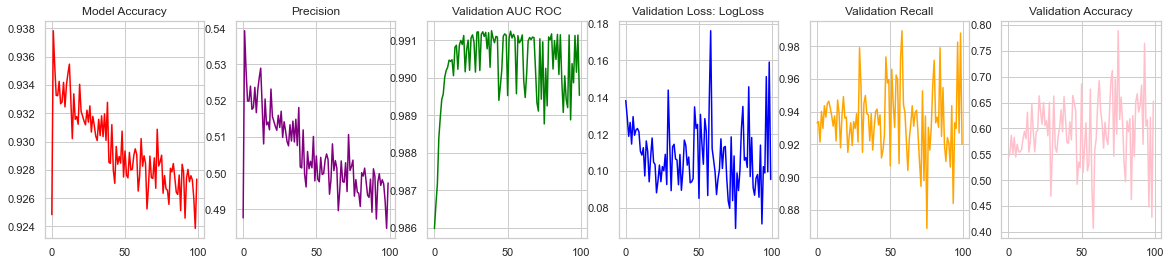

In [ ]:
#plot the history of the different evaluation metrics in each iteration of the neural network to observe the improvement in different key evaluation metrics

#metrics=['accuracy', 'AUC', 'Precision', 'Recall', 'TrueNegatives', 'TruePositives'])

# plot differences
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
axes[0].plot(r.history['accuracy'], label='accuracy', color='red')
axes[1].plot(r.history['precision'], label='loss', color='purple')
axes[2].plot(r.history['val_auc'], label='val_AUC', color='green')
axes[3].plot(r.history['val_loss'], label='val_loss', color='blue')
axes[4].plot(r.history['val_recall'], label='val_recall', color='orange')
axes[5].plot(r.history['val_precision'], label='val_precision', color='pink')


axes[0].title.set_text('Model Accuracy')
axes[1].title.set_text('Precision')
axes[2].title.set_text('Validation AUC ROC')
axes[3].title.set_text('Validation Loss: LogLoss')
axes[4].title.set_text('Validation Recall')
axes[5].title.set_text('Validation Accuracy')

In [ ]:
# Convert all the outputs to booleans (just makes it easier to see)
threshold = 0.5

y_pred = model_nn_weighted.predict(X_test_scale)
y_pred = y_pred > threshold
y_test = y_test > threshold

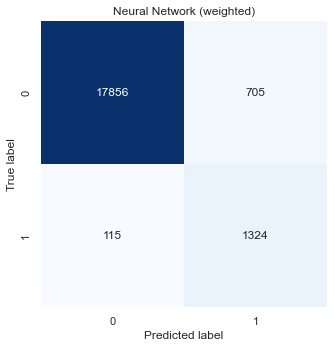

In [ ]:
# create a confusion matrix to visualize results

from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
mat = confusion_matrix(y_test, y_pred.round())
sns.heatmap(mat, square=True, cmap="Blues", annot=True, fmt='d', cbar=False)
ax.title.set_text("Neural Network (weighted)")
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.tight_layout()  
plt.show()

In [ ]:
# accuracy metrics

y_test = y_test.astype(int)
y_pred = y_pred.astype(int)


f1 = round(f1_score(y_test,y_pred),3)
recall = round(recall_score(y_test,y_pred),3)
precision = round(precision_score(y_test,y_pred),3)
accuracy = round(accuracy_score(y_test,y_pred),3)
rocauc = round(roc_auc_score(y_test,y_pred),3)
logloss = 0.1117
Correct_Predictions_tunned_noOS = int(accuracy * len(y_test))
Incorrect_Predictions_tunned_noOS = int(len(y_test) - (accuracy * len(y_test)))

results_df_tunned_noOS['NeuralNetwork'] = ([f1, recall, precision, accuracy, rocauc, logloss,Correct_Predictions_tunned_noOS,Incorrect_Predictions_tunned_noOS])

results_df_tunned_noOS.head(8)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
F1_tunned_noOS,0.663,0.584,0.655,0.901,NaN,0.706,0.7640
Recall_tunned_noOS,0.962,0.985,0.953,0.835,NaN,0.964,0.9200
Precision_tunned_noOS,0.506,0.415,0.499,0.980,NaN,0.557,0.6530
Accuracy Score_tunned_noOS,0.930,0.899,0.928,0.987,NaN,0.942,0.9590
ROC AUC_tunned_noOS,0.945,0.939,0.939,0.917,NaN,0.952,0.9410
LogLoss_tunned_noOS,0.149,0.200,0.237,0.051,NaN,0.107,0.1117
Correct_Predictions_tunned_noOS,18600.000,17980.000,18560.000,19740.000,NaN,18840.000,19180.0000
Incorrect_Predictions_tunned_noOS,1400.000,2020.000,1440.000,260.000,NaN,1160.000,820.0000


# Compile all results and draw conclusions

In [ ]:
results_list = [results_df, results_df_norm, results_df_smote, results_df_tunned,results_df_tunned_noOS]

all_results = pd.concat(results_list)

all_results.tail(5)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
Accuracy Score_tunned_noOS,0.930,0.899,0.928,0.987,NaN,0.942,0.9590
ROC AUC_tunned_noOS,0.945,0.939,0.939,0.917,NaN,0.952,0.9410
LogLoss_tunned_noOS,0.149,0.200,0.237,0.051,NaN,0.107,0.1117
Correct_Predictions_tunned_noOS,18600.000,17980.000,18560.000,19740.000,NaN,18840.000,19180.0000
Incorrect_Predictions_tunned_noOS,1400.000,2020.000,1440.000,260.000,NaN,1160.000,820.0000


In [ ]:
roc_list = ['ROC AUC', 'ROC AUC_norm', 'ROC AUC_smote', 'ROC AUC_tunned','ROC AUC_tunned_noOS']

roc_auc_df = all_results[all_results.index.isin(roc_list)]

roc_auc_df.head(5)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
ROC AUC,0.877,0.921,0.922,0.918,0.921,0.924,0.878
ROC AUC_norm,0.877,0.925,0.919,0.917,0.921,0.924,0.918
ROC AUC_smote,0.943,0.922,0.922,0.917,0.932,0.926,0.943
ROC AUC_tunned,0.942,0.924,0.901,0.918,0.932,0.929,NaN
ROC AUC_tunned_noOS,0.945,0.939,0.939,0.917,NaN,0.952,0.941


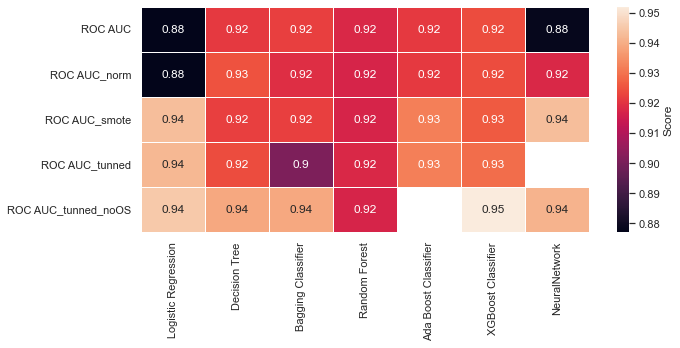

In [ ]:
# create heatmap to visualize algorithm performance

fig, ax = plt.subplots(figsize=(10,5))

ax = sns.heatmap(roc_auc_df,
                 annot=True,
                 linewidths=.5,
                 cbar_kws={"label":"Score"})

plt.tight_layout()  
plt.show()

Important to note that almost all models achieve a higher ROC AUC score with the dataset that has not been oversampled using SMOTE. It could be that during the process of oversampling some important characteristics are lost and therefore cause the resulting model to perform worse against the test dataset.

In [ ]:
recall_list = ['Recall', 'Recall_norm', 'Recall_smote', 'Recall_tunned','Recall_tunned_noOS']

recall_df = all_results[all_results.index.isin(recall_list)]

recall_df.head(5)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
Recall,0.767,0.855,0.846,0.837,0.846,0.850,0.758
Recall_norm,0.767,0.862,0.841,0.836,0.846,0.850,0.847
Recall_smote,0.939,0.860,0.850,0.836,0.880,0.856,0.940
Recall_tunned,0.947,0.864,0.853,0.839,0.880,0.870,NaN
Recall_tunned_noOS,0.962,0.985,0.953,0.835,NaN,0.964,0.920


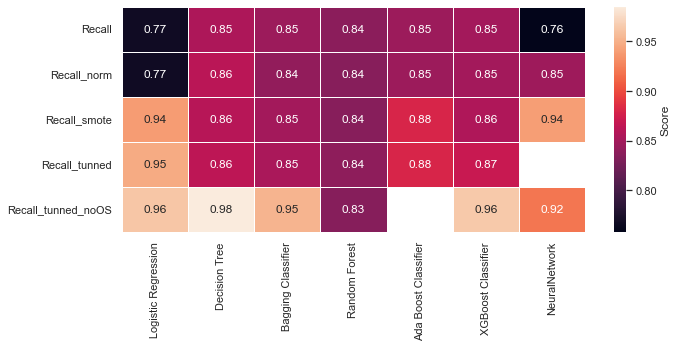

In [ ]:
# create heatmap to visualize algorithm performance

fig, ax = plt.subplots(figsize=(10,5))

ax = sns.heatmap(recall_df,
                 annot=True,
                 linewidths=.5,
                 cbar_kws={"label":"Score"})

plt.tight_layout()  
plt.show()

In [ ]:
precision_list = ['Precision', 'Precision_norm', 'Precision_smote', 'Precision_tunned','Precision_tunned_noOS']

precision_df = all_results[all_results.index.isin(precision_list)]

precision_df.head(5)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
Precision,0.821,0.844,0.972,0.980,0.941,0.971,0.950
Precision_norm,0.820,0.844,0.970,0.980,0.941,0.971,0.866
Precision_smote,0.581,0.807,0.922,0.968,0.818,0.946,0.575
Precision_tunned,0.537,0.805,0.567,0.966,0.818,0.849,NaN
Precision_tunned_noOS,0.506,0.415,0.499,0.980,NaN,0.557,0.653


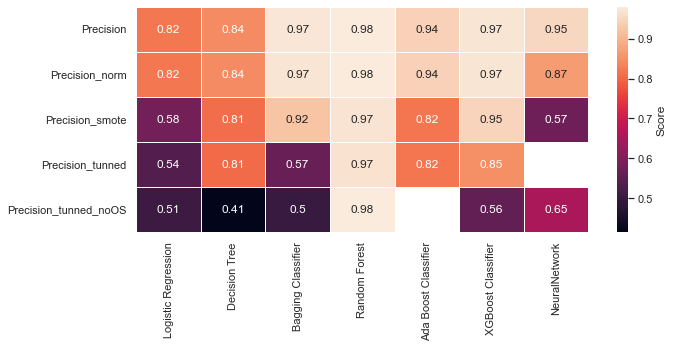

In [ ]:
# create heatmap to visualize algorithm performance

fig, ax = plt.subplots(figsize=(10,5))

ax = sns.heatmap(precision_df,
                 annot=True,
                 linewidths=.5,
                 cbar_kws={"label":"Score"})

plt.tight_layout()  
plt.show()

In [ ]:
positivenegative_list = ['Correct_Predictions','Incorrect_Predictions','Correct_Predictions_norm','Incorrect_Predictions_norm',
                         'Correct_Predictions_smote','Incorrect_Predictions_smote','Correct_Predictions_tunned','Incorrect_Predictions_tunned',
                         'Correct_Predictions_tunned_noOS','Incorrect_Predictions_tunned_noOS']

all_results[all_results.index.isin(positivenegative_list)].head(24)

,Logistic Regression,Decision Tree,Bagging Classifier,Random Forest,Ada Boost Classifier,XGBoost Classifier,NeuralNetwork
Correct_Predictions,19420.0,19560.0,19740.0,19740.0,19700.0,19740.0,19600.0
Incorrect_Predictions,580.0,440.0,260.0,260.0,300.0,260.0,400.0
Correct_Predictions_norm,19420.0,19580.0,19740.0,19740.0,19700.0,19740.0,19600.0
Incorrect_Predictions_norm,580.0,420.0,260.0,260.0,300.0,260.0,400.0
Correct_Predictions_smote,18940.0,19500.0,19680.0,19720.0,19540.0,19720.0,18920.0
Incorrect_Predictions_smote,1060.0,500.0,320.0,280.0,460.0,280.0,1080.0
Correct_Predictions_tunned,18760.0,19500.0,18860.0,19720.0,19540.0,19600.0,NaN
Incorrect_Predictions_tunned,1240.0,500.0,1140.0,280.0,460.0,400.0,NaN
Correct_Predictions_tunned_noOS,18600.0,17980.0,18560.0,19740.0,NaN,18840.0,19180.0
Incorrect_Predictions_tunned_noOS,1400.0,2020.0,1440.0,260.0,NaN,1160.0,820.0


Final commentary on the metrics and the models:

The loss function I’ve used throughout the project is the logarithmic loss function (logloss). In general terms a lower log loss value means that the model is able to provide better predictions. In mathematical terms the logloss is the negative average of the log of the corrected predicted probabilities for each instance (Setia, 2020). The metric itself is a measure of how the predicted probabilities correspond to the actual values for each class. 

The goal of this project was to classify whether a transaction is potentially fraudulent or not. To do that I've optimised the algorithms towards the ROC AUC score which combines the "True Positive Rate" (TPR) and "False Positive Rate" (FPR). A model that classifies all the observations correctly would have ROC AUC Score of 1, therefore the closer the ROC AUC Score to 1 the better. 

But really given that problem that we're dealing with here, the goal of a good classification algorithm should be to minimise as much as possible the chances of having a fraudulent transaction go through. In that respect the best metric to use would be "Recall", because it tells us what percentage of positive instances are classified as such by the algorithm. From that perspecive the Decision tree classifier achieves the higher recall of all models with an incredible 98% for the model that doesn't use oversampling and is tunned to account for the class imbalance. 

However, there's a problem with looking at just at recall and that is the amount of false positives that can be flagged as a result. The decision tree classifier achieves a very low precision rate of 42% which means that less than half of the instances it's classifying as positive are actually positive. In a real world scenario this would lead to many credit card customers being disturbed by having their transactions wrongly flagged as fraudulent. So a decision would need to be made on what's an acceptable rate of precision. 

The XGBoost classifier would represent a great alternative since it achieves a marginally lower recall at 97% but with a much higher precision rate at 55% something that is also reflected in its F1 score (70%) and log loss (0.11).Unsurprisingly it also achieve the highest ROC AUC of all the models with recall > 90%. The author opines that this should be the model to apply. 



# References

Setia, M. (2020) Binary Cross Entropy aka Log Loss-The cost function used in Logistic Regression. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/11/binary-cross-entropy-aka-log-loss-the-cost-function-used-in-logistic-regression/.

xgboost developers (2021) XGBoost Documentation. https://xgboost.readthedocs.io/en/latest/parameter.html.

Hosmer, D.W., Lemeshow, S. & Sturdivant, R. (2013) Applied Logistic Regression, 3rd Edition. Wiley. https://learning.oreilly.com/library/view/applied-logistic-regression/9781118548356/.

Jolly, K. (2018) Machine Learning with scikit-learn Quick Start Guide. Packt. https://learning.oreilly.com/library/view/machine-learning-with/9781789343700/.

Google (2022) TensorFlow Blog. https://www.tensorflow.org/tutorials/structured_data/imbalanced_data.

Ng, A. (2020) Machine Learning, Stanford University. https://www.coursera.org/learn/machine-learning



Wade, C. & Glynn, K. (2020) Hands-On Gradient Boosting with XGBoost and scikit-learn. Packt. https://learning.oreilly.com/library/view/hands-on-gradient-boosting/9781839218354/.




